## Imports

In [87]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_1samp
import seaborn as sns

# part 1

## Get the data

In [88]:
df = pd.read_csv('GooglePlay.csv')
# print(df)
# df_test = pd.read_csv('heart_attack_prediction_dataset.csv')
# list(df['Last Updated'].value_counts().keys())
# df.loc[:,'Category']
# list(df['Content Rating'].value_counts().keys())
# l = []
# for i in df['Genres'].value_counts().keys():
#     l+= i.split(';')
# set(l)
# df[df['Content Rating'] == 'Adults only 18+']
# df['Installs'].value_counts()
# df.iloc[100:160]
# df 


## Get All data

In [89]:
df1 = pd.read_csv('source_Playstore_final.csv')


C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\2439137224.py:1: DtypeWarning: Columns (7,12,29,30,33,35,37,38,40,42,43,44,46,47,48,49,50,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('source_Playstore_final.csv')


## check dataset playstore

In [90]:
# df1.iloc[100:160]
# list(df1['Developer Email'].value_counts().keys())
# df.loc[:,'Category']
# df1['Category'].value_counts()
# unique_keys = set(df1['App Id'].value_counts().keys())

# l = []
# for i in df['Genres'].value_counts().keys():
#     l+= i.split(';')
# set(l)
# df[df['Content Rating'] == 'Adults only 18+']
# df['Installs'].value_counts()
# df.iloc[100:160]
# unique_keys
# df1.columns
list(df1['Minimum Installs'].value_counts().keys())


[10000.0,
 1000.0,
 100000.0,
 100.0,
 5000.0,
 50000.0,
 500.0,
 10.0,
 1000000.0,
 500000.0,
 50.0,
 10000000.0,
 5000000.0,
 5.0,
 1.0,
 0.0,
 50000000.0,
 100000000.0,
 500000000.0,
 1000000000.0,
 5000000000.0,
 10000000000.0]

## prepare numerical data

In [91]:
# get numerical columns
columns = df.columns
numerical_columns = {"Rating": df['Rating'],
                     "Reviews": df['Reviews'],
                     "Size": df['Size'],
                     "Installs": df['Installs'],
                     "Price": df['Price']}
# we will extract the numbers and store the cleaned data in the dict below
cleaned_numerical_columns = {}
# drop missing data = NoN rows
for col in numerical_columns.keys():
    numerical_columns[col].dropna(inplace=True)

## check what is the structure of data in each column

In [92]:
for col_name in numerical_columns.keys():
    data_without_digits = np.array([])
    for data in numerical_columns[col_name]:
        data_without_digits = np.append(data_without_digits, re.sub(r'\d+', '', str(data)))

    # save each structure once
    data_without_digits = np.unique(data_without_digits)
    print(f"column <{col_name}>, extera characters:", data_without_digits, end='\n')

column <Rating>, extera characters: ['.']
column <Reviews>, extera characters: ['']
column <Size>, extera characters: ['.M' '.k' 'M' 'Varies with device' 'k']
column <Installs>, extera characters: ['' '+' ',+' ',,+' ',,,+']
column <Price>, extera characters: ['' '$. ']


## Add 'Rating' and 'Review' columns in cleaned_numerical_columns, because they're already clean

In [93]:
cleaned_numerical_columns['Rating'] = numerical_columns['Rating']
cleaned_numerical_columns['Reviews'] = numerical_columns['Reviews']

## 'Size' column: Remove not numerical data

In [94]:
pattern = r'^\d+(\.\d+)?[Mk]$'
for index, data in enumerate(numerical_columns['Size']):
    if not (re.match(pattern, data)):
        numerical_columns['Size'].drop(index, inplace=True)

## 'Size' column: Extract numbers from combined data

In [95]:
def convert_to_integer(data):
    if data.endswith('M'):
        return int(float(data[:-1]) * 1e6)  # Convert M to millions
    elif data.endswith('k'):
        return int(float(data[:-1]) * 1e3)  # Convert k to thousands
    else:
        return int(data)


# convert combined data into integer
cleaned_numerical_columns['Size'] = numerical_columns['Size'].apply(convert_to_integer)

## 'Installs' column: remove extra characters like ',' and '+'

In [96]:
cleaned_numerical_columns['Installs'] = numerical_columns['Installs'].apply(
    lambda x: int(''.join(filter(str.isdigit, x))))

## 'Price' column: remove $

In [97]:
cleaned_numerical_columns['Price'] = numerical_columns['Price'].apply(lambda x: float(x.replace('$', '')))

## analyse columns

In [98]:
# create a dict to store mean, max,... values for each attr
analyse_attrs = {key: [] for key in cleaned_numerical_columns.keys()}

for key in cleaned_numerical_columns.keys():
    # get the data of a column/attr
    data = cleaned_numerical_columns[key]
    attr_name = key
    attr_type = type(data[0])
    value_range = (data.min(), data.max())
    min_val = data.min()
    max_val = data.max()
    mean_val = data.mean()
    mode_val = data.mode()[0]
    median_val = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)].tolist()
    analyse_attrs[key] = [attr_name, attr_type, value_range, min_val, max_val, mean_val, mode_val, median_val, outliers]

In [99]:
# save the result dataframe
labels = ['attr_name', 'attr_type', 'value_range', 'min_val', 'max_val', 'mean_val', 'mode_val', 'median_val',
          'outliers']
analyse_attrs = pd.DataFrame(analyse_attrs, index=labels)
analyse_attrs.T.to_csv('part1_analyse_attrs.csv', index=False)
analyse_attrs.T

,attr_name,attr_type,value_range,min_val,max_val,mean_val,mode_val,median_val,outliers
Rating,Rating,<class 'numpy.float64'>,"(1.0, 5.0)",1.0,5.0,4.191757,4.4,4.3,"[3.2, 3.2, 3.1, 3.2, 3.2, 2.6, 3.1, 3.0, 1.9, ..."
Reviews,Reviews,<class 'numpy.int64'>,"(0, 78158306)",0,78158306,444152.896033,0,2094.0,"[215644, 194216, 224399, 295221, 174531, 27192..."
Size,Size,<class 'numpy.int64'>,"(8500, 100000000)",8500,100000000,21516529.515582,11000000,13000000.0,"[73000000, 77000000, 70000000, 77000000, 84000..."
Installs,Installs,<class 'numpy.int64'>,"(0, 1000000000)",0,1000000000,15464338.882565,1000000,100000.0,"[50000000, 100000000, 100000000, 1000000000, 5..."
Price,Price,<class 'numpy.float64'>,"(0.0, 400.0)",0.0,400.0,1.027368,0.0,0.0,"[4.99, 4.99, 4.99, 4.99, 3.99, 3.99, 6.99, 1.4..."


## BoxPlot for outliers

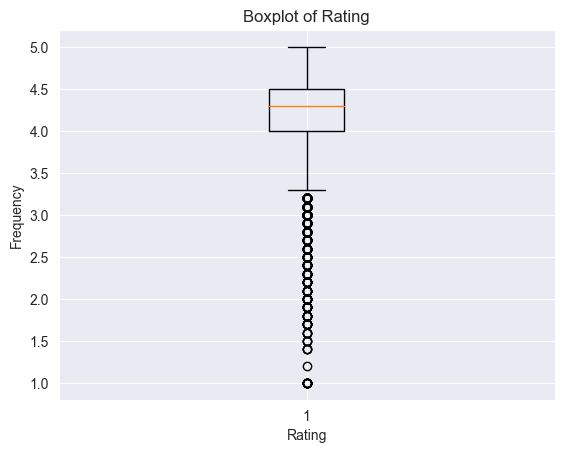

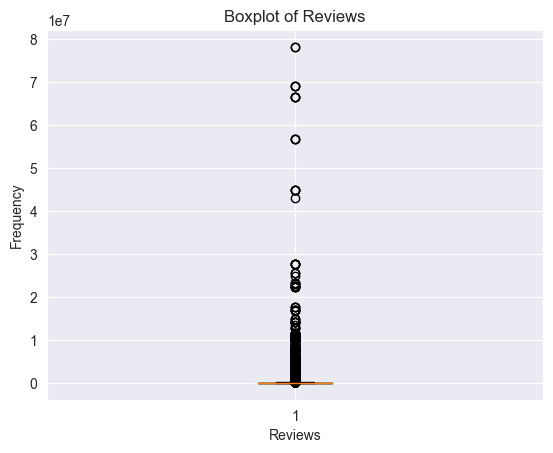

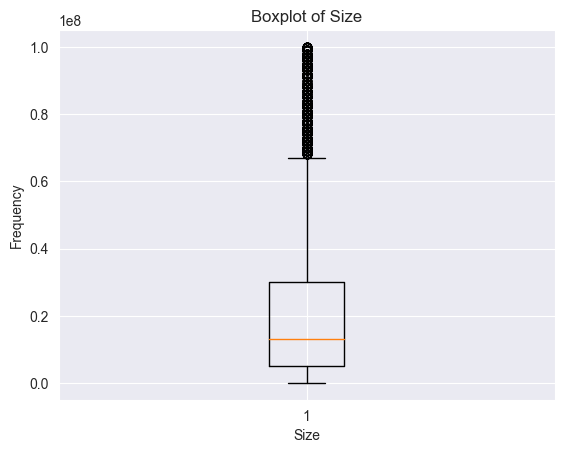

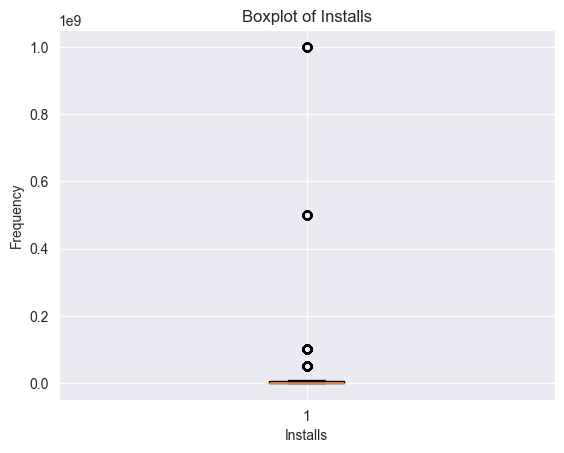

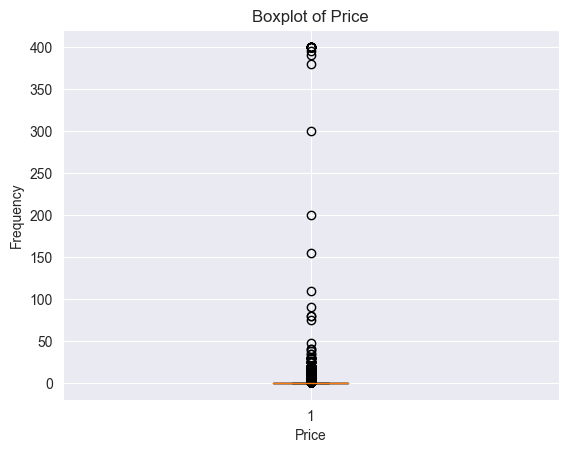

In [100]:
# Check if the directory 'boxPlots' exists, and create it if it doesn't
directory = 'part1_boxPlots'
if not os.path.exists(directory):
    os.makedirs(directory)
# make boxPlots
for key in cleaned_numerical_columns.keys():
    # get a column of data
    data = cleaned_numerical_columns[key]
    # create boxplot
    plt.boxplot(data)
    # Add labels and title
    plt.xlabel(key)
    plt.ylabel('Frequency')
    plt.title(f'Boxplot of {key}')
    plt.savefig(f'part1_boxPlots/boxplot_{key}.png')
    plt.show()

## Quality table dataset googleplay

In [101]:
quality_table = pd.DataFrame(index=list(df.columns),
                             columns=["No.records", "No.Null", "Accuracy", "Completeness", "Validity", "Currentness",
                                      "Consistency"])
columns_to_check = df.columns

## Quality table dataset playstore

In [102]:
quality_table1 = pd.DataFrame(index=list(df1.columns),
                              columns=["No.records", "No.Null", "Accuracy", "Completeness", "Validity", "Currentness",
                                       "Consistency"])
columns_to_check1 = df1.columns

## Number of record dataset google paly

In [103]:
for column in columns_to_check:
    quality_table['No.records'][column] = len(df)
# quality_table  

## Nunmber of record dataset playstore

In [104]:
for column in columns_to_check1:
    quality_table1['No.records'][column] = len(df1)
# quality_table  

## Missing value dataset googleplay

In [105]:
missing_values = {}
for column in columns_to_check:
    missing_values[column] = df[df[column].isna()]

## Missing value dataset playstore

In [106]:
missing_values1 = {}
for column in columns_to_check1:
    missing_values1[column] = df1[df1[column].isna()]


## Invalid value dataset googleplay

In [107]:
def pattern_validation(inp, pattern):
    return inp.str.match(pattern)


def boundary_validation(inp, start, end):
    return ((inp >= start) & (inp <= end))


def isin_validation(inp, range):
    return inp.isin(range)


df['Current Ver'] = df['Current Ver'].astype(str)
df['Android Ver'] = df['Android Ver'].astype(str)
df['Last Updated'] = df['Last Updated'].astype(str)
# df['Price'] = df['Price'].astype(str)
invalid_values = {}
for column in columns_to_check:
    if column == 'Category':
        new_df = df[df['Category'].notna()]
        invalid_values[column] = new_df[~isin_validation(new_df['Category'],
                                                         ['FAMILY', 'GAME', 'TOOLS', 'MEDICAL', 'BUSINESS',
                                                          'PRODUCTIVITY', 'PERSONALIZATION', 'COMMUNICATION', 'SPORTS',
                                                          'LIFESTYLE', 'FINANCE', 'HEALTH_AND_FITNESS', 'PHOTOGRAPHY',
                                                          'SOCIAL', 'NEWS_AND_MAGAZINES', 'SHOPPING',
                                                          'TRAVEL_AND_LOCAL', 'DATING', 'BOOKS_AND_REFERENCE',
                                                          'VIDEO_PLAYERS', 'EDUCATION', 'ENTERTAINMENT',
                                                          'MAPS_AND_NAVIGATION', 'FOOD_AND_DRINK', 'HOUSE_AND_HOME',
                                                          'AUTO_AND_VEHICLES', 'LIBRARIES_AND_DEMO', 'WEATHER',
                                                          'ART_AND_DESIGN', 'EVENTS', 'PARENTING', 'COMICS', 'BEAUTY'])]
    elif column == 'Rating':
        new_df = df[df['Rating'].notna()]
        invalid_values[column] = new_df[~boundary_validation(new_df['Rating'], 0, 5)]
    elif column == 'Reviews':
        new_df = df[df['Reviews'].notna()]
        invalid_values[column] = new_df[~boundary_validation(new_df['Reviews'], 0, np.inf)]
    elif column == 'Size':
        new_df = df[df['Size'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Size'], '[0-9]')]
    elif column == 'Content Rating':
        new_df = df[df['Content Rating'].notna()]
        invalid_values[column] = new_df[~isin_validation(new_df['Content Rating'],
                                                         ['Everyone', 'Teen', 'Mature 17+', 'Everyone 10+',
                                                          'Adults only 18+', 'Unrated'])]
    elif column == 'Genres':
        new_df = df[df['Genres'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Genres'], '^[\w\s&;]+$')]
    elif column == 'Last Updated':
        new_df = df[df['Last Updated'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Last Updated'], '[0-9]{2}-[A-Z][a-z]{2}-[0-9]{2}')]
    elif column == 'Current Ver':
        new_df = df[df['Current Ver'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Current Ver'], '^\d+(\.\d+)*$')]
    elif column == 'Android Ver':
        new_df = df[df['Android Ver'].notna()]
        invalid_values[column] = new_df[
            ~pattern_validation(new_df['Android Ver'], '\d+(\.\d+)*\s*-\s*\d+(\.\d+)*|\d+(\.\d+)*\s+and\s+up')]
    elif column == 'Type':
        new_df = df[df['Type'].notna()]
        invalid_values[column] = new_df[~isin_validation(new_df['Type'], ['Free', 'Paid'])]
    elif column == 'Installs':
        new_df = df[df['Installs'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Installs'], '^\d+(,\d+)*\+$|0')]
    elif column == 'Price':
        new_df = df[df['Price'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Price'], '^\$?\d+(\.\d{2})?|0')]
# invalid_values['Category']

## save each column dataset Googleplay as a CSV 

In [108]:
# testdf = pd.DataFrame(invalid_values['Price'])
# testdf.to_csv('invalid_value_googlepaly\Price.csv')

## Invalid value dataset playstore

In [109]:
def pattern_validation(inp, pattern):
    return inp.str.match(pattern)


def boundary_validation(inp, start, end):
    return ((inp >= start) & (inp <= end))


def isin_validation(inp, range):
    return inp.isin(range)


invalid_values1 = {}
df1['Size'] = df1['Size'].astype(str)
df1['Minimum Android'] = df1['Minimum Android'].astype(str)
df1['Developer Id'] = df1['Developer Id'].astype(str)
df1['Developer Internal ID'] = df1['Developer Internal ID'].astype(str)
df1['Developer Website'] = df1['Developer Website'].astype(str)
df1['Developer Email'] = df1['Developer Email'].astype(str)

for column in columns_to_check1:
    if column == 'Category':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column], ['Education', 'Tools', 'Books & Reference',
                                                                             'Personalization', 'Music & Audio',
                                                                             'Entertainment', 'Lifestyle', 'Business',
                                                                             'Productivity', 'Health & Fitness',
                                                                             'Puzzle', 'Travel & Local', 'Casual',
                                                                             'Photography', 'Sports', 'Finance',
                                                                             'Simulation', 'News & Magazines', 'Arcade',
                                                                             'Shopping', 'Food & Drink',
                                                                             'Communication', 'Action', 'Educational',
                                                                             'Social', 'Medical', 'Adventure',
                                                                             'Maps & Navigation', 'Role Playing',
                                                                             'Video Players & Editors', 'Art & Design',
                                                                             'Racing', 'Board', 'Strategy', 'Card',
                                                                             'Word', 'Auto & Vehicles', 'Weather',
                                                                             'Trivia', 'House & Home', 'Beauty',
                                                                             'Dating', 'Casino', 'Libraries & Demo',
                                                                             'Events', 'Music', 'Parenting', 'Comics'])]
    elif column == 'Rating':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, 5)]
    elif column == 'Rating Count':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Installs':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d+(,\d+)*\+$|0')]
    elif column == 'Minimum Installs':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Free':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column], ['False', 'True'])]
    elif column == 'Price':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Currency':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column],
                                                           ['USD', 'XXX', 'EUR', 'INR', 'GBP', 'PKR', 'THB', 'HKD',
                                                            'TRY', 'RUB', 'VND', 'BDT', 'BGN', 'KRW', 'IDR', 'UAH',
                                                            'CAD', 'AUD', 'SGD', 'JPY', 'RSD', 'ZAR', 'PEN', 'PLN',
                                                            'ILS', 'CHF', 'AED', 'BRL', 'DKK', 'NGN', 'KES', 'CZK',
                                                            'MYR', 'EGP', 'NZD', 'TWD', 'SEK', 'MXN', 'LKR', 'HUF',
                                                            'KZT', 'COP', 'DZD', 'LBP', 'TZS', 'GHS', 'BOB'])]
    elif column == 'Size':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d+(\.\d+)?[MK]$')]
    elif column == 'Minimum Android':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d+(\.\d+)*$|4.4W')]
    elif column == 'Developer Id':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[isin_validation(new_df1[column], ['nan'])]
    elif column == 'Developer Website':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^(?:[Hh][Tt][Tt][Pp][Ss]?://)[^\s]+')]
    elif column == 'Developer Email':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[
            ~pattern_validation(new_df1[column], '[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2}(?:\.[A-Za-z]{2})?')]
    elif column == 'Released' or column == 'Last update':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[
            ~pattern_validation(new_df1[column], '\d{1,2}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}')]
    elif column == 'Privacy Policy':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^(?:[Hh][Tt][Tt][Pp][Ss]?://)[^\s]+')]
    elif column == 'Content Rating':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column],
                                                           ['Everyone', 'Teen', 'Mature 17+', 'Everyone 10+',
                                                            'Adults only 18+', 'Unrated'])]
    elif column == 'Ad Supported' or column == 'In app purchases' or column == 'Editor Choice':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column], [True, False])]
    elif column == 'Reviews':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Developer Internal ID':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d\.\d+[Ee]\+\d+')]
    elif column == 'Android version Text':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[
            ~pattern_validation(new_df1[column], '^(?:\d+(\.\d+)*\s?(?:[-_]\s?\d+(\.\d+)*)?\s?(?:and up)?)$')]
        #\d+(\.\d+)*(\s*-\s*\d+(\.\d+)*)?W*(\d+(\.\d+)*)?\s*(and\s*up)?
    elif column == 'Version':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\s*\d+(\.\d+)*$')]
# invalid_values1

## save each column dataset Playstore as a CSV 

In [110]:
# testdf = pd.DataFrame(invalid_values1['Last update'])
# testdf.to_csv('invalid_value_Playstore\Last update1111.csv')

## Number of Nulls dataset Googleplay

In [111]:
for column in columns_to_check:
    df[column] = df[column].apply(lambda x: np.nan if x == 'nan' else x)
    quality_table['No.Null'][column] = df[column].isnull().sum()

## Number of Nulls dataset Playstore

In [112]:
for column in columns_to_check1:
    df1[column] = df1[column].apply(lambda x: np.nan if x == 'nan' else x)
    quality_table1['No.Null'][column] = df1[column].isnull().sum()

## Validity of dataset Googleplay

In [113]:
dlen = len(df)

for item in invalid_values:
    quality_table['Validity'][item] = (1 - (len(invalid_values[item].index) / dlen)) * 100
# quality_table


## Validity of dataset Playstore

In [114]:
dlen = len(df1)
for item in invalid_values1:
    quality_table1['Validity'][item] = (1 - (len(invalid_values1[item].index) / dlen)) * 100

# quality_table1

## Completeness of dataset Googleplay

In [115]:
# completeness
dlen = len(df)
for item in missing_values:
    quality_table['Completeness'][item] = (1 - (len(missing_values[item]) / dlen)) * 100
# quality_table

## Completeness of dataset Playstore

In [116]:
# completeness
dlen = len(df1)
for item in missing_values1:
    quality_table1['Completeness'][item] = (1 - (len(missing_values1[item]) / dlen)) * 100
# quality_table

## Accuracy of dataset Googleplay

In [117]:
dlen = len(df)
for column in columns_to_check:
    if column in missing_values and column in invalid_values:
        accuracy = (1 - ((len(missing_values[column]) + len(invalid_values[column].index.unique())) / dlen)) * 100
        # print(column)
        # print(len(missing_values[column]) + len(invalid_values[column].index))
        # print(dlen)
        # print(accuracy)
        quality_table['Accuracy'][column] = accuracy
    else:
        quality_table['Accuracy'][column] = 100.0  # Assuming completeness if data is not missing or invalid
# quality_table


## Accuracy of dataset Playstore

In [118]:
dlen = len(df1)
for column in columns_to_check1:
    if column in missing_values1 and column in invalid_values1:
        accuracy = (1 - ((len(missing_values1[column]) + len(invalid_values1[column].index.unique())) / dlen)) * 100
        # print(column)
        # print(len(missing_values[column]) + len(invalid_values[column].index))
        # print(dlen)
        # print(accuracy)
        quality_table1['Accuracy'][column] = accuracy
    else:
        quality_table1['Accuracy'][column] = 100.0  # Assuming completeness if data is not missing or invalid


## Currentness of dataset Googleplay

In [119]:
from datetime import datetime

# percentage valid data before 2017
# new_df = df[ df['Last Updated'].notna() ]
# valid_date = new_df[~pattern_validation(new_df1['Last Updated'],'[0-9]{2}-[A-Z][a-z]{2}-[0-9]{2}')]  
# valid_date['Year'] = valid_date['Last Updated'].apply(lambda x: int(x[-2:]))
# valid_dates_before_2018 = valid_date[valid_date['Year'] < 17]
# percentage_valid_before_2017 = (len(valid_dates_before_2018) / len(valid_date)) * 100
# for column in df.columns:
#     if column != 'Unnamed: 0':  
#         quality_table['Currentness'][column]=percentage_valid_before_2017

# min time since last update
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
current_date = datetime.now()
time_since_last_update = current_date - df['Last Updated']
quality_table['Currentness'] = time_since_last_update.min()  # minimum time elapsed as a measure of currentness
quality_table

C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\515585911.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Last Updated'] = pd.to_datetime(df['Last Updated'])


,No.records,No.Null,Accuracy,Completeness,Validity,Currentness,Consistency
Unnamed: 0,10840,0,100.0,100.0,NaN,2155 days 01:52:27.682313,NaN
App,10840,0,100.0,100.0,NaN,2155 days 01:52:27.682313,NaN
Category,10840,0,100.0,100.0,100.0,2155 days 01:52:27.682313,NaN
Rating,10840,1474,86.402214,86.402214,100.0,2155 days 01:52:27.682313,NaN
Reviews,10840,0,100.0,100.0,100.0,2155 days 01:52:27.682313,NaN
Size,10840,0,84.363469,100.0,84.363469,2155 days 01:52:27.682313,NaN
Installs,10840,0,100.0,100.0,100.0,2155 days 01:52:27.682313,NaN
Type,10840,1,99.990775,99.990775,100.0,2155 days 01:52:27.682313,NaN
Price,10840,0,100.0,100.0,100.0,2155 days 01:52:27.682313,NaN
Content Rating,10840,0,100.0,100.0,100.0,2155 days 01:52:27.682313,NaN


## Currentness of dataset Playstore

In [120]:
from datetime import datetime

# percentage valid data before 2017
# new_df1 = df1[ df1['Last Updated'].notna() ]
# valid_date1 = new_df1[~pattern_validation(new_df['Last Updated'],'[0-9]{2}-[A-Z][a-z]{2}-[0-9]{2}')]  
# valid_date1['Year'] = valid_date1['Last Updated'].apply(lambda x: int(x[-2:]))
# valid_dates_before_2018 = valid_date1[valid_date['Year'] < 17]
# percentage_valid2_before_2017 = (len(valid_dates_before_2018) / len(valid_date1)) * 100
# for column in df.columns:
#     if column != 'Unnamed: 0':  
#         quality_table1['Currentness'][column]=percentage_valid2_before_2017

# min time since last update 
df1['Last update'] = pd.to_datetime(df1['Last update'], errors='coerce')
errors_index = df1[df1['Last update'].isna()].index
# print(df1.loc[errors_index])
current_date = datetime.now()
time_since_last_update = current_date - df1['Last update']
quality_table1.loc['Last update', 'Currentness'] = time_since_last_update.min()
quality_table1

C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\180751972.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Last update'] = pd.to_datetime(df1['Last update'], errors='coerce')


,No.records,No.Null,Accuracy,Completeness,Validity,Currentness,Consistency
App Name,450794,13,100.0,99.997116,NaN,NaN,NaN
App Id,450794,0,100.0,100.0,NaN,NaN,NaN
Category,450794,13,99.997116,99.997116,100.0,NaN,NaN
Rating,450794,2812,99.376212,99.376212,100.0,NaN,NaN
Rating Count,450794,118768,73.653598,73.653598,100.0,NaN,NaN
Installs,450794,91,99.979813,99.979813,100.0,NaN,NaN
Minimum Installs,450794,13,99.997116,99.997116,100.0,NaN,NaN
Free,450794,92,0.0,99.979592,0.020408,NaN,NaN
Price,450794,92,99.979592,99.979592,100.0,NaN,NaN
Currency,450794,92,99.979592,99.979592,100.0,NaN,NaN


## Consistency between Category and Genres dataset Googleplay

In [121]:
# Check consistency between Category and Genres
# Define a function to perform the required transformations
def transform_genre(genre):
    return genre.replace('&', 'AND').replace(' ', '_').upper()


# Apply the transformation function to the 'Genres' column and save into another list
transformed_genres = df['Genres'].apply(transform_genre).tolist()
inconsistent_genres = df[~df['Category'].isin(transformed_genres)]
inconsistent_genres


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1653,1653,ROBLOX,GAME,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
1654,1654,Subway Surfers,GAME,4.5,27722264,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,2018-07-12,1.90.0,4.1 and up
1655,1655,Candy Crush Saga,GAME,4.4,22426677,74M,"500,000,000+",Free,0,Everyone,Casual,2018-07-05,1.129.0.2,4.1 and up
1656,1656,Solitaire,GAME,4.7,254258,23M,"10,000,000+",Free,0,Everyone,Card,2018-08-01,2.137.0,4.1 and up
1657,1657,Bubble Shooter,GAME,4.5,148897,46M,"10,000,000+",Free,0,Everyone,Casual,2018-07-17,1.20.1,4.0.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,10823,List iptv FR,VIDEO_PLAYERS,NaN,1,2.9M,100+,Free,0,Everyone,Video Players & Editors,2018-04-22,1,4.0.3 and up
10826,10827,Fr Agnel Ambarnath,FAMILY,4.2,117,13M,"5,000+",Free,0,Everyone,Education,2018-06-13,2.0.20,4.0.3 and up
10833,10834,FR Calculator,FAMILY,4.0,7,2.6M,500+,Free,0,Everyone,Education,2017-06-18,1.0.0,4.1 and up
10835,10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,2017-07-25,1.48,4.1 and up


## Consistency between Android Ver and Current Ver dataset Googleplay

In [122]:
# Check consistency between Android Ver and Current Ver
inconsistent_android_version = df[df.apply(lambda x: str(x['Android Ver']) not in str(x['Current Ver']), axis=1)]
inconsistent_android_version

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833,10834,FR Calculator,FAMILY,4.0,7,2.6M,500+,Free,0,Everyone,Education,2017-06-18,1.0.0,4.1 and up
10834,10835,FR Forms,BUSINESS,NaN,0,9.6M,10+,Free,0,Everyone,Business,2016-09-29,1.1.5,4.0 and up
10835,10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,2017-07-25,1.48,4.1 and up
10836,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,2018-07-06,1,4.1 and up


## Consistansy between Type and Price dataset Googleplay

In [123]:
inconsistent_price = df[(df['Type'] == 'FREE') & (df['Price'] != 0) | (df['Type'] == 'Paid') & (df['Price'] == 0)]
# inconsistent_price

## Consistency between Rating count and Reviews dataset playstor

In [124]:
# Check consistency between Rating and Reviews
inconsistent_rating_reviews = df1[df1['Rating Count'] > df1['Reviews']]
inconsistent_rating_reviews

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Logistics Management,com.eniseistudio.logistics_management,Education,4.090909,66.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Estados Unidos Noticias,com.eniseistudio.news.estados_unidos,News & Magazines,4.000000,8.0,"1,000+",1000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dental Assistant,com.eniseistudio.dental_assistant,Education,3.866667,15.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Medical Assistant,com.eniseistudio.course.medical_assistant,Education,4.000000,18.0,"5,000+",5000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Business Administration,com.eniseistudio.majors.course.business_admini...,Education,4.023256,86.0,"50,000+",50000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450788,Sinhala Keyboard,com.fancy.fontforu.sinhalesekeyboard,Productivity,4.370000,326.0,"50,000+",50000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450789,Punjabi Keyboard,com.fancy.fontforu.punjabikeyboard,Productivity,4.240000,875.0,"100,000+",100000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450790,Live 4D Wallpaper 2020 : 4K Live Backgrounds,com.fancy.hdwallpaper.parallaxbackgroundhd,Personalization,2.961539,52.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450791,Rap Music Maker : Rap Beats Music Recording St...,com.fancy.rapmusicmakerstudio,Music & Audio,3.500000,64.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Consistansy between Last update and Released dataset Playstore

In [125]:
df1['Last update'] = pd.to_datetime(df1['Last update'], errors='coerce')
df1['Released'] = pd.to_datetime(df1['Released'], errors='coerce')

errors_index = df1[df1['Last update'].isna()].index
errors_index = df1[df1['Released'].isna()].index
inconsistent_update_released = df1[df1['Last update'] < df1['Released']]
inconsistent_update_released


C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\2027301640.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Released'] = pd.to_datetime(df1['Released'], errors='coerce')


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
930,Resume Builder Free,nithra.resume.maker.cv.builder.app,Business,4.090000,804.0,"100,000+",100000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4227,Rock Space,com.rockspace.ss,Arcade,4.920000,25.0,100+,100.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5546,हिंदी पहेलियाँ (Puzzles),com.hindipaheli,Entertainment,4.000000,32.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5547,"Personality Development - Communication, Social",com.parsonalitytricks,Social,4.386138,427.0,"100,000+",100000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6950,Axe Warrior: Ultimate Battleground Axe Champion,com.sablo.axe.slapio,Action,3.058824,17.0,"5,000+",5000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448324,Dog Town Simulator : My Pet Farm Town,com.fls.dog.farm.simulator,Role Playing,3.901961,359.0,"50,000+",50000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448339,Keyboard Plus - #1 Emoji Keyboard App,com.keyideas.keyboard.emoji,Tools,4.000000,22.0,"1,000+",1000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448995,YMCA of South Florida,com.netpulse.mobile.ymcasouthflorida,Health & Fitness,4.777778,36.0,"1,000+",1000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450700,Visitors Book,com.nsk.visitors,Education,0.000000,NaN,100+,100.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Consistansy between Free and Price dataset playstore

In [126]:
inconsistent_price = df1[(df1['Free'] == 'TRUE') & (df1['Price'] == 0) | (df1['Free'] == 'FALSE') & (df1['Price'] != 0)]
inconsistent_price

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56


## Consistency between minimum installs and installs dataset playstor

In [127]:
import pandas as pd


# Function to convert Installs strings to minimum installs
def convert_installs_to_minimum(installs):
    # Define a dictionary to map install ranges to their minimum value
    install_mapping = {
        '0+': 0,
        '1+': 1,
        '5+': 5,
        '10+': 10,
        '50+': 50,
        '100+': 100,
        '500+': 500,
        '1,000+': 1000,
        '5,000+': 5000,
        '10,000+': 10000,
        '50,000+': 50000,
        '100,000+': 100000,
        '500,000+': 500000,
        '1,000,000+': 1000000,
        '5,000,000+': 5000000,
        '10,000,000+': 10000000,
        '50,000,000+': 50000000,
        '100,000,000+': 100000000,
        '500,000,000+': 500000000,
        '1,000,000,000+': 1000000000,
        '5,000,000,000+': 5000000000,
        '10,000,000,000+': 10000000000
    }
    # Check if installs is NaN, return NaN
    if pd.isna(installs):
        return pd.NA
    # Return the minimum installs based on the install range
    return install_mapping[installs]


# Convert Installs to Minimum Installs
df1['Converted Installs'] = df1['Installs'].apply(convert_installs_to_minimum)

# Check for consistency between Converted Installs and Minimum Installs
inconsistent_install = df1[df1['Converted Installs'] != df1['Minimum Installs']]

# Display inconsistent rows
inconsistent_install




,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Converted Installs
13103,NaN,id.akusantri.wallpapermuslimahhd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17210,Claire’s Café: Tasty Cuisine 🥞🧁🍔,com.gamehouse.cc1,Casual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19030,LOST in Blue(Global),com.volcanoforce.lost.global,Adventure,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19196,Mafia Crime War,com.onemt.mafiacrimewar,Role Playing,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19197,Modern Dead,and.onemt.moderndead,Strategy,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272281,Zombie Wasteland Adventure,com.daviddickball.zombiewasteland,Adventure,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291626,NaN,com.aramex.ecourier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291897,NaN,com.winrgames.letsleap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292192,NaN,com.newspitara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## schema level 

In [128]:
# from fuzzywuzzy import fuzz
#
#
# # Function to calculate similarity using Levenshtein distance
# def levenshtein_similarity(str1, str2):
#     return fuzz.ratio(str1.lower(), str2.lower())
#
#
# # Set a threshold for similarity score
# threshold = 90  # You can adjust this threshold as needed
#
# # Create a list to store potential duplicate pairs
# duplicate_pairs = []
#
# # Iterate through the DataFrame to compare pairs of records
# for i in range(len(df)):
#     for j in range(i + 1, len(df)):
#         record1 = df.loc[i, 'App']
#         record2 = df.loc[j, 'App']
#         similarity_score = levenshtein_similarity(record1, record2)
#         if similarity_score >= threshold:
#             duplicate_pairs.append((record1, record2, similarity_score))
#
# # Display potential duplicate pairs
# for pair in duplicate_pairs:
#     print(f"Potential duplicate pair: {pair}")

## Single Source Problem - Schema Level
### googlePlay dataset:
- **Price column:** dolor sign isn't used for value 0.
- **Current Ver column:** the value 'varies with device' is been used with type numeric.
- **Android Ver column:** the value 'varies with device' is been used with type numeric.
### playStore dataset
- **Rating column:** common type for rating is a decimal number with one decimal place, but here theres more decimal places for some records.
- **Rating Count column:** the type of this column should be numeric but some records have value 'N/A'.
- **Price column:** dolor sign isn't used for the values of this column.
## Single Source Problem - Instance Level
### googlePlay dataset
- **Current Ver column:** dummy value for record number 3613 (value = Natalia Studio Development )
- **Rating column:** missing value for some records. 
### playStore dataset: 
- **Developer Address:** dummy values for some records like record number 450547 (value = æ…ˆæž—é•‡è¥¿èŒƒæ‘).
- **Developer Address:** misfielded values for some records like record number 61 (value = kefar truman rony.arbiv@gmail.com)
## Multi Source Problem – Schema Level
- two different values for the rating of a single app 'Smoke Effect Photo Maker - Smoke Editor'.
- different format for describing if the app is free or not. for googleplay dataset it's determined in column 'Type' with categorical values 'Free' and 'Paid', while for playstore dataset it's determined in column 'Free' with binary values 'TRUE' and 'FALSE'.

## phase1 - part4

### Load

In [129]:
df = pd.read_csv('GooglePlay.csv')
df1 = pd.read_csv('source_Playstore_final.csv')
# remove columns named 'Unnamed' in df1
columns_to_drop = [col for col in df1.columns if 'Unnamed' in col]
df1 = df1.drop(columns=columns_to_drop)
df = df.drop(columns='Unnamed: 0')

C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\196749835.py:2: DtypeWarning: Columns (7,12,29,30,33,35,37,38,40,42,43,44,46,47,48,49,50,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('source_Playstore_final.csv')


### find columns with the same names

In [130]:
columns_to_check = df.columns
columns_to_check1 = df1.columns
same_columns = [col for col in columns_to_check if col in columns_to_check1]
dif_col_in_googleplay = [col for col in columns_to_check if col not in columns_to_check1]
dif_col_in_playstore = [col for col in columns_to_check1 if col not in columns_to_check]
print('#-- same cols:', same_columns)
print('#-- googleplay dif cols:', dif_col_in_googleplay)
print('#-- palystore dif cols:', dif_col_in_playstore)

#-- same cols: ['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Content Rating']
#-- googleplay dif cols: ['App', 'Type', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
#-- palystore dif cols: ['App Name', 'App Id', 'Rating Count', 'Minimum Installs', 'Free', 'Currency', 'Minimum Android', 'Developer Id', 'Developer Website', 'Developer Email', 'Released', 'Last update', 'Privacy Policy', 'Ad Supported', 'In app purchases', 'Editor Choice', 'Summary', 'Android version Text', 'Developer', 'Developer Address', 'Developer Internal ID', 'Version']


### creating combined dataframe

In [131]:
combined_df = pd.merge(df, df1, left_on='App', right_on='App Name', how='inner')
print(len(combined_df))
combined_df

6250


,App,Category_x,Rating_x,Reviews_x,Size_x,Installs_x,Type,Price_x,Content Rating_x,Genres,...,Ad Supported,In app purchases,Editor Choice,Summary,Reviews_y,Android version Text,Developer,Developer Address,Developer Internal ID,Version
0,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,...,True,False,False,Prank your Parents or Friends with Smoke Effec...,448.0,4.0.3 and up,Anzu Dev,NaN,7.028150e+18,1.1
1,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,...,NaN,True,False,"Painting, drawing, & sketching",42184.0,7.0 and up,Infinite Studio LLC,1155 SEMINOLE TRAIL\nPO BOX 6402\nCHARLOTTESVI...,8.161090e+18,6.6.1
2,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,...,True,True,False,A magical mind journey in Colorfit Garden Colo...,5589.0,4.1 and up,Colorfit,Flat 11 1/F Block 10 Shek Lei (2) Estate ...,7.021960e+18,3.2.1
3,Tattoo Name On My Photo Editor,ART_AND_DESIGN,4.2,44829,20M,"10,000,000+",Free,0,Teen,Art & Design,...,True,False,False,This is the perfect tattoo maker app with thou...,41.0,4.4 and up,Voodamdee,NaN,8.883360e+18,1.5
4,Tattoo Name On My Photo Editor,ART_AND_DESIGN,4.2,44829,20M,"10,000,000+",Free,0,Teen,Art & Design,...,True,False,False,Tattoo my photo with my name is tattoo design ...,20280.0,4.2 and up,iDroid Solution,"Surat, Gujarat, India",5.388640e+18,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,Poker Pro.Fr,GAME,4.2,5442,17M,"100,000+",Free,0,Teen,Card,...,True,True,False,Texas Poker Pro offers the most comprehensive ...,1431.0,4.1 and up,Century Games Limited,"Ugland House, KY-Grand Cayman KY1-1104, Cayman...",8.152170e+18,6.0.0
6246,Golden Dictionary (FR-AR),BOOKS_AND_REFERENCE,4.2,5775,4.9M,"500,000+",Free,0,Everyone,Books & Reference,...,True,False,False,"Multilingual Dictionary, (in Arabic Dictionary...",2384.0,4.1 and up,Golden-Soft,www.golden-soft.net,6.582520e+18,21.0.3.08
6247,HTC Sense Input - FR,TOOLS,4.0,885,8.0M,"100,000+",Free,0,Everyone,Tools,...,NaN,False,False,Download this add-on to improve word predictio...,232.0,5.0 and up,HTC Corporation,"88 Section 3, Zhongxing Road, Xindian District...",5.004080e+18,1.0.612928
6248,Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,Varies with device,"5,000,000+",Free,0,Mature 17+,Social,...,True,True,False,"Say hi to people around the world online, chat...",31826.0,Varies with device,My Friends Social,"6, Vasili Vryonides str. Gala Court Chambers, ...",5.961610e+18,Varies with device


In [132]:
# save combined dataframe as csv
# combined_df.to_csv('combined_df.csv', index=False)

### combine Category columns

#### analyse Category column

In [133]:
# compare values of category column in both datasets

# unique categories in df
category_1 = sorted(pd.Series(df['Category'].unique()).map(lambda x: str(x).lower().replace('_', ' ')))
print(f'#-- category 1 (df):\n {category_1}\n#-- counts: {len(category_1)}\n')

# unique categories in df1
category_2 = (sorted(pd.Series(df1['Category'].unique()).map(lambda x: str(x).lower().replace('&', 'and'))))
print(f'#-- category 2 (df1):\n {category_2}\n#-- counts: {len(category_2)}\n')

# find common categories
common_categories = [cate for cate in category_2 if cate in category_1]
print(f'#-- common categories:\n {common_categories}\n#-- counts: {len(common_categories)}\n')

# find different categories in df
diff_categories_1 = [cate for cate in category_1 if cate not in category_2]
print(f'#-- different categories 1:\n {diff_categories_1}\n#-- counts: {len(diff_categories_1)}\n')

# find different categories in df1
diff_categories_2 = [cate for cate in category_2 if cate not in category_1]
print(f'#-- different categories 2:\n {diff_categories_2}\n#-- counts: {len(diff_categories_2)}')

#-- category 1 (df):
 ['art and design', 'auto and vehicles', 'beauty', 'books and reference', 'business', 'comics', 'communication', 'dating', 'education', 'entertainment', 'events', 'family', 'finance', 'food and drink', 'game', 'health and fitness', 'house and home', 'libraries and demo', 'lifestyle', 'maps and navigation', 'medical', 'news and magazines', 'parenting', 'personalization', 'photography', 'productivity', 'shopping', 'social', 'sports', 'tools', 'travel and local', 'video players', 'weather']
#-- counts: 33

#-- category 2 (df1):
 ['action', 'adventure', 'arcade', 'art and design', 'auto and vehicles', 'beauty', 'board', 'books and reference', 'business', 'card', 'casino', 'casual', 'comics', 'communication', 'dating', 'education', 'educational', 'entertainment', 'events', 'finance', 'food and drink', 'health and fitness', 'house and home', 'libraries and demo', 'lifestyle', 'maps and navigation', 'medical', 'music', 'music and audio', 'nan', 'news and magazines', 'pare

#### find inconsistency in categories

In [134]:
count_inconsistent_cats = 0
for i in range(len(combined_df['Category_x'])):
    if combined_df['Category_x'][i].lower().replace('_', ' ') != combined_df['Category_y'][i].lower().replace('&',
                                                                                                              'and'):
        print(f"{i}> {combined_df['Category_x'][i]}: {combined_df['Category_y'][i]}")
        count_inconsistent_cats += 1
print(f'#-- count inconsistent: {count_inconsistent_cats}')

6> ART_AND_DESIGN: Entertainment
7> ART_AND_DESIGN: Casual
8> ART_AND_DESIGN: Entertainment
9> ART_AND_DESIGN: Entertainment
10> ART_AND_DESIGN: Casual
12> ART_AND_DESIGN: Entertainment
18> ART_AND_DESIGN: Books & Reference
20> FAMILY: Art & Design
22> ART_AND_DESIGN: House & Home
27> AUTO_AND_VEHICLES: Maps & Navigation
32> AUTO_AND_VEHICLES: Shopping
37> BEAUTY: Photography
38> BEAUTY: Photography
40> BEAUTY: Lifestyle
50> BOOKS_AND_REFERENCE: Education
55> BOOKS_AND_REFERENCE: Education
56> BOOKS_AND_REFERENCE: Tools
57> BOOKS_AND_REFERENCE: Education
58> BOOKS_AND_REFERENCE: Education
59> BOOKS_AND_REFERENCE: Education
60> BOOKS_AND_REFERENCE: Education
61> BOOKS_AND_REFERENCE: Education
63> BOOKS_AND_REFERENCE: Education
64> BOOKS_AND_REFERENCE: Education
68> BOOKS_AND_REFERENCE: Education
71> BOOKS_AND_REFERENCE: Education
72> BOOKS_AND_REFERENCE: Education
73> BOOKS_AND_REFERENCE: Education
74> BOOKS_AND_REFERENCE: Education
75> BOOKS_AND_REFERENCE: Education
76> BOOKS_AND_REFER

#### handle inconsistency in category

In [135]:
# category_x -> df  , category_y -> df1
# fill nulls in playstore dataset (source)(df1) with the value of googleplay dataset (df)
# (there is no null values in this column)
combined_df['Category_y'] = combined_df['Category_y'].fillna(combined_df['Category_x'])

# category column that has handled inconsistency in category columns
handled_category = pd.Series()

for i in range(len(combined_df['Category_x'])):
    if combined_df['Category_x'][i].lower().replace('_', ' ') != combined_df['Category_y'][i].lower().replace('&',
                                                                                                              'and'):
        # if values are different, fill it with the value of source dataset (playstore).
        handled_category[len(handled_category)] = combined_df['Category_y'][i]
    else:
        # if values are the same, fill it with the value from either 'Category_y' or 'Category_x'
        handled_category[len(handled_category)] = combined_df['Category_y'][i]

# add the handled category column to the combined dataframe, and also drop category_y and category_x columns
combined_df = combined_df.drop(columns=['Category_x', 'Category_y'])
combined_df['Category'] = handled_category
combined_df['Category']

0            Art & Design
1            Art & Design
2            Art & Design
3            Art & Design
4            Art & Design
              ...        
6245                 Card
6246    Books & Reference
6247                Tools
6248               Social
6249            Education
Name: Category, Length: 6250, dtype: object

### combine Rating columns

#### find inconsistency in ratings

In [136]:
inconsistent_rates = [(rate_x, round(rate_y, 1)) for rate_x, rate_y in
                      zip(combined_df['Rating_x'], combined_df['Rating_y']) if rate_x != round(rate_y, 1)]
print(inconsistent_rates)
print(f'count inconsistent rates: {len(inconsistent_rates)}')

[(3.8, 3.1), (4.1, 4.0), (4.4, 4.3), (4.2, 4.1), (4.2, 4.1), (4.2, 4.1), (4.6, 0.0), (4.6, 0.0), (4.6, 0.0), (4.6, 3.8), (4.6, 4.0), (4.6, 4.4), (4.4, 4.0), (4.5, 3.6), (4.6, 4.5), (4.7, 4.2), (4.1, 3.6), (4.1, 3.3), (4.7, 4.5), (4.7, 4.5), (4.1, 4.2), (4.1, 2.1), (4.6, 4.4), (4.2, 4.0), (3.9, 3.2), (4.4, 4.3), (4.5, 3.2), (4.0, 0.0), (3.9, 4.2), (4.6, 4.4), (4.6, 4.1), (4.6, 4.1), (4.2, 3.4), (4.0, 4.1), (3.8, 3.7), (4.4, 4.5), (4.2, 4.7), (4.2, 4.7), (4.5, 4.3), (4.5, 4.4), (4.5, 4.4), (4.5, 4.4), (4.6, 4.5), (4.2, 4.5), (4.2, 0.0), (4.2, 4.4), (4.2, 0.0), (4.2, 3.9), (4.2, 0.0), (4.2, 0.0), (4.2, 0.0), (4.2, 4.5), (4.2, 4.5), (4.2, 4.6), (4.2, 4.1), (4.2, 4.9), (4.2, 4.4), (4.2, 0.0), (4.2, 4.1), (4.2, 4.4), (4.2, 0.0), (4.2, 3.9), (4.2, 0.0), (4.2, 0.0), (4.2, 0.0), (4.2, 4.5), (4.2, 4.5), (4.2, 4.6), (4.2, 4.1), (4.2, 4.9), (4.2, 4.4), (4.2, 0.0), (4.2, 4.1), (4.2, 4.4), (4.2, 0.0), (4.3, 4.5), (4.7, 3.9), (4.7, 3.9), (4.1, 4.3), (4.1, 4.3), (4.6, 0.0), (4.6, 4.8), (4.6, 4.4), (4.

#### handle inconsistency in rating

In [137]:
# Assuming combined_df is already defined

# rating column that has handled inconsistency in rating columns
handled_rating = []

for index, row in combined_df.iterrows():
    rate_x = row['Rating_x']
    rate_y = row['Rating_y']

    if pd.notnull(rate_x) and pd.notnull(rate_y):
        if rate_x != round(rate_y, 1):
            # if values are different, fill them with the mean of them.
            handled_rating.append(np.mean([rate_x, round(rate_y, 1)]))
        else:
            # if values are the same, fill it with the value from either 'Rating_x' or 'Rating_y'
            handled_rating.append(rate_x)
    elif pd.isnull(rate_x):
        # If 'Rating_x' is null, fill it with the value from 'Rating_y'
        handled_rating.append(rate_y)
    elif pd.isnull(rate_y):
        # If 'Rating_y' is null, fill it with the mean of non-null values from 'Rating_y'
        non_null_y_ratings = combined_df.loc[combined_df['Rating_y'].notnull(), 'Rating_y']
        handled_rating.append(np.mean(non_null_y_ratings))

# Add the handled rating column to the combined dataframe
combined_df['Rating'] = handled_rating

# Drop 'Rating_x' and 'Rating_y' columns
combined_df = combined_df.drop(columns=['Rating_x', 'Rating_y'])

combined_df['Rating'].fillna(combined_df['Rating'].mean(), inplace=True)
# drop the one NAN value remained
# combined_df = combined_df.drop(combined_df[combined_df['Rating'].isnull()].index)

### combine Reviews columns

#### find inconsistency in reviews

In [138]:
inconsistent_reviews = [(review_x, review_y) for review_x, review_y in
                        zip(combined_df['Reviews_x'], combined_df['Reviews_y']) if review_x != review_y]
print(f'count inconsistent reviews: {len(inconsistent_reviews)}')
inconsistent_reviews

count inconsistent reviews: 6208


[(178, 448.0),
 (36815, 42184.0),
 (13791, 5589.0),
 (44829, 41.0),
 (44829, 20280.0),
 (44829, 41.0),
 (4326, 0.0),
 (4326, 0.0),
 (4326, 0.0),
 (4326, 9.0),
 (4326, 28588.0),
 (4326, 2040.0),
 (1518, 2032.0),
 (27, 49.0),
 (224399, 857765.0),
 (20260, 15475.0),
 (227, 26.0),
 (227, 5.0),
 (1015, 8.0),
 (8145, 2532.0),
 (8264, 2532.0),
 (36639, 36576.0),
 (36639, 212.0),
 (2431, 2964.0),
 (40211, 10080.0),
 (40211, 10080.0),
 (52530, 15697.0),
 (3574, 8127.0),
 (142, 589.0),
 (21777, 7254.0),
 (13372, 5228.0),
 (3617, 6.0),
 (1288, 0.0),
 (32090, 9163.0),
 (4369, 22429.0),
 (4369, 2403.0),
 (4369, 2403.0),
 (17934, 866.0),
 (17934, 4102.0),
 (113715, 30144.0),
 (9, 170.0),
 (577550, 109693.0),
 (814080, 321503.0),
 (814151, 321503.0),
 (246315, 67060.0),
 (454060, 135475.0),
 (454412, 135475.0),
 (155446, 53788.0),
 (155466, 53788.0),
 (203130, 46156.0),
 (1435, 2826.0),
 (90468, 25886.0),
 (860, 75.0),
 (860, 0.0),
 (860, 2075.0),
 (860, 3625.0),
 (860, 0.0),
 (87873, 20.0),
 (87873,

#### handle inconsistency in reviews

In [139]:
combined_df['Reviews_y'] = combined_df['Reviews_y'].fillna(combined_df['Reviews_x'])

# we handle it with the mean of reviews
handled_reviews = (combined_df['Reviews_x'] + combined_df['Reviews_y']) / 2

combined_df = combined_df.drop(columns=['Reviews_x', 'Reviews_y'])
combined_df['Reviews'] = handled_reviews
combined_df['Reviews']

0         313.0
1       39499.5
2        9690.0
3       22435.0
4       32554.5
         ...   
6245     3436.5
6246     4079.5
6247      558.5
6248    60156.0
6249       40.0
Name: Reviews, Length: 6250, dtype: float64

### combine Size columns


#### find inconsistency in sizes

In [140]:
inconsistent_sizes = [(size_x, size_y) for size_x, size_y in
                      zip(combined_df['Size_x'], combined_df['Size_y']) if size_x != size_y]
print(f'count inconsistent sizes: {len(inconsistent_sizes)}')
inconsistent_sizes

count inconsistent sizes: 5048


[('29M', '124M'),
 ('33M', '39M'),
 ('20M', '30M'),
 ('20M', '23M'),
 ('20M', '30M'),
 ('21M', '37M'),
 ('21M', '30M'),
 ('21M', '5.4M'),
 ('21M', '32M'),
 ('21M', '37M'),
 ('21M', '38M'),
 ('37M', 'Varies with device'),
 ('17M', '23M'),
 ('31M', '27M'),
 ('25M', '26M'),
 ('5.2M', '7.8M'),
 ('5.2M', '21M'),
 ('11M', '3.7M'),
 ('24M', '14M'),
 ('24M', '14M'),
 ('Varies with device', '5.4M'),
 ('Varies with device', '4.7M'),
 ('2.4M', 'Varies with device'),
 ('Varies with device', '7.4M'),
 ('Varies with device', '7.4M'),
 ('7.0M', '8.1M'),
 ('3.9M', '5.5M'),
 ('32M', '25M'),
 ('Varies with device', '17M'),
 ('Varies with device', '25M'),
 ('7.9M', '8.1M'),
 ('4.5M', '5.5M'),
 ('Varies with device', '3.5M'),
 ('14M', '17M'),
 ('14M', '24M'),
 ('14M', '24M'),
 ('Varies with device', '4.9M'),
 ('Varies with device', '54M'),
 ('Varies with device', '13M'),
 ('Varies with device', '114M'),
 ('Varies with device', '114M'),
 ('Varies with device', '54M'),
 ('Varies with device', '54M'),
 ('2.8

#### handle inconsistency in sizes

In [141]:
def convert_to_integer(value):
    value = value.replace(',', '')
    if value.endswith('M'):
        return int(float(value[:-1]) * 1e6)  # Convert M to millions
    elif value.endswith('k'):
        return int(float(value[:-1]) * 1e3)  # Convert k to thousands
    elif value.endswith('G'):
        return int(float(value[:-1]) * 1e9)  # Convert k to billions
    else:
        return int(value)

In [142]:
handled_size = pd.Series()

for size_x, size_y in zip(combined_df['Size_x'], combined_df['Size_y']):
    if size_x == 'Varies with device' and size_y == 'Varies with device':
        handled_size[len(handled_size)] = 'Varies with device'
    elif size_x != 'Varies with device' and size_y == 'Varies with device':
        handled_size[len(handled_size)] = convert_to_integer(size_x)
    elif size_x == 'Varies with device' and size_y != 'Varies with device':
        handled_size[len(handled_size)] = convert_to_integer(size_y)
    else:  # both are numbers
        if abs(convert_to_integer(size_x) - convert_to_integer(size_y)) <= min(
                convert_to_integer(size_x), convert_to_integer(size_y)) / 2:
            handled_size[len(handled_size)] = str(np.mean([convert_to_integer(size_x), convert_to_integer(size_y)]))
        else:
            handled_size[len(handled_size)] = convert_to_integer(size_y)

combined_df = combined_df.drop(columns=['Size_x', 'Size_y'])
combined_df['Size'] = handled_reviews
combined_df['Size']

0         313.0
1       39499.5
2        9690.0
3       22435.0
4       32554.5
         ...   
6245     3436.5
6246     4079.5
6247      558.5
6248    60156.0
6249       40.0
Name: Size, Length: 6250, dtype: float64

### combine Installs columns

#### find inconsistency in installs

In [143]:
inconsistent_install = [(install_x, install_y) for install_x, install_y in
                        zip(combined_df['Installs_x'], combined_df['Installs_y']) if install_x != install_y]
print(f'count inconsistent installs: {len(inconsistent_install)}')
inconsistent_install

count inconsistent installs: 4085


[('50,000+', '100,000+'),
 ('1,000,000+', '10,000,000+'),
 ('10,000,000+', '10,000+'),
 ('10,000,000+', '10,000+'),
 ('100,000+', '50+'),
 ('100,000+', '50+'),
 ('100,000+', '500+'),
 ('100,000+', '5,000+'),
 ('100,000+', '10,000,000+'),
 ('100,000+', '500,000+'),
 ('100,000+', '500,000+'),
 ('10,000+', '50,000+'),
 ('10,000,000+', '100,000,000+'),
 ('500,000+', '1,000,000+'),
 ('50,000+', '500,000+'),
 ('50,000+', '1,000+'),
 ('100,000+', '1,000+'),
 ('5,000,000+', '10,000,000+'),
 ('5,000,000+', '100,000+'),
 ('100,000+', '500,000+'),
 ('1,000,000+', '5,000,000+'),
 ('50,000+', '100,000+'),
 ('100,000+', '500,000+'),
 ('100,000+', '100+'),
 ('1,000,000+', '5,000,000+'),
 ('100,000+', '5,000,000+'),
 ('100,000+', '1,000,000+'),
 ('100,000+', '1,000,000+'),
 ('1,000,000+', '500,000+'),
 ('5,000+', '100,000+'),
 ('10,000,000+', '50,000,000+'),
 ('500,000+', '1,000,000+'),
 ('100,000+', '50,000+'),
 ('100,000+', '5,000+'),
 ('100,000+', '1,000,000+'),
 ('100,000+', '1,000,000+'),
 ('100,

#### handle inconsistency in Installs

In [144]:
# remove extra characters like ',' and '+'
combined_df['Installs_x'] = combined_df['Installs_x'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
combined_df['Installs_y'] = combined_df['Installs_y'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

In [145]:
handled_install = pd.Series()

normal_install_diff = 100

for install_x, install_y in zip(combined_df['Installs_x'], combined_df['Installs_y']):
    if abs(install_x - install_y) <= normal_install_diff:
        handled_install[len(handled_install)] = str(np.mean([install_x, install_y]))
    else:
        handled_install[len(handled_install)] = install_y

combined_df = combined_df.drop(columns=['Installs_x', 'Installs_y'])
combined_df['Installs'] = handled_install
combined_df['Installs']

0           100000
1         10000000
2        1000000.0
3            10000
4       10000000.0
           ...    
6245      100000.0
6246       1000000
6247        500000
6248     5000000.0
6249         10000
Name: Installs, Length: 6250, dtype: object

### combine Price columns

#### find inconsistency in prices

In [146]:
combined_df['Price_x'] = combined_df['Price_x'].apply(lambda x: float(x.replace('$', '')))

In [147]:
inconsistent_prices = [(price_x, price_y) for price_x, price_y in
                       zip(combined_df['Price_x'], combined_df['Price_y']) if price_x != price_y]
print(f'count inconsistent prices: {len(inconsistent_prices)}')
inconsistent_prices

count inconsistent prices: 219


[(0.0, 1.49),
 (0.0, 1.49),
 (4.99, 5.99),
 (4.99, 5.99),
 (4.99, 5.99),
 (4.99, 5.99),
 (3.99, 4.99),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (6.99, 0.0),
 (1.49, 0.0),
 (4.99, 0.0),
 (4.99, 0.0),
 (4.99, 0.0),
 (0.0, 2.49),
 (0.0, 0.99),
 (0.0, 2.49),
 (0.0, 0.99),
 (0.0, 2.49),
 (0.0, 0.99),
 (0.0, 1.99),
 (0.0, 1.99),
 (0.0, 1.99),
 (0.0, 1.99),
 (1.99, 3.99),
 (4.99, 4.49),

#### handle inconsistency in price

In [148]:
handled_price = pd.Series()

normal_price_diff = 1

for price_x, price_y in zip(combined_df['Price_x'], combined_df['Price_y']):
    if abs(price_x - price_y) <= normal_price_diff:
        handled_price[len(handled_price)] = str(np.mean([price_x, price_y]))
    else:
        handled_price[len(handled_price)] = price_y

combined_df = combined_df.drop(columns=['Price_x', 'Price_y'])
combined_df['Price'] = handled_price
combined_df['Price']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6245    0.0
6246    0.0
6247    0.0
6248    0.0
6249    0.0
Name: Price, Length: 6250, dtype: object

### combine Content rating columns

#### find inconsistency in Content rating

In [149]:
inconsistent_content_rating = [(content_rating_x, content_rating_y) for content_rating_x, content_rating_y in
                               zip(combined_df['Content Rating_x'], combined_df['Content Rating_y']) if
                               content_rating_x != content_rating_y]
print(f'count inconsistent content rating: {len(inconsistent_content_rating)}')
inconsistent_content_rating

count inconsistent content rating: 378


[('Everyone', 'Teen'),
 ('Everyone', 'Everyone 10+'),
 ('Everyone', 'Teen'),
 ('Everyone', 'Teen'),
 ('Everyone', 'Teen'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Teen', 'Everyone'),
 ('Everyone', 'Teen'),
 ('Everyone', 'Teen'),
 ('Everyone', 'Everyone 10+'),
 ('Everyone', 'Everyone 10+'),
 ('Everyone', 'Everyone 10+'),
 ('Everyone', 'Mature 17+'),
 ('Everyone', 'Everyone 10+'),
 ('Everyone', 'Mature 17+'),
 ('Ev

#### handle inconsistency in content rating

In [150]:
combined_df['Content Rating'] = combined_df['Content Rating_y']
combined_df = combined_df.drop(columns=['Content Rating_x', 'Content Rating_y'])
combined_df['Content Rating']

0         Everyone
1         Everyone
2             Teen
3             Teen
4             Teen
           ...    
6245          Teen
6246          Teen
6247      Everyone
6248    Mature 17+
6249      Everyone
Name: Content Rating, Length: 6250, dtype: object

### combine Type and Free columns

#### conver TRUE to 0 and FALSE to 1 in Free columns

In [151]:
# save combined dataframe as csv
# combined_df.to_csv('combined_df.csv', index=False)
# combined_df['Currency'].isnull().sum()
# combined_df['Free'].value_counts()
# combined_df['Type'].value_counts()
combined_df['Free'] = combined_df['Free'].replace({True: 0, False: 1})
combined_df['Free'].value_counts()

Free
0    5892
1     358
Name: count, dtype: int64

#### conver Free to 0 and paid to 1 in Type columns

In [152]:
combined_df['Type'] = combined_df['Type'].replace({'Free': 0, 'Paid': 1})
combined_df['Type'].value_counts()


Type
0    5849
1     401
Name: count, dtype: int64

#### find inconsistency in Type and Free

In [153]:
combined_df['Type'] != combined_df['Free']


0       False
1       False
2       False
3       False
4       False
        ...  
6245    False
6246    False
6247    False
6248    False
6249    False
Length: 6250, dtype: bool

#### merge Type and Free and save as Type columns 

In [154]:
# Check for inconsistencies and missing values between 'Type' and 'Free'
inconsistent_mask = (combined_df['Type'] == 0) & (combined_df['Free'] != 0)
missing_mask = (combined_df['Type'].isnull()) | (combined_df['Free'].isnull())

# Handle inconsistencies and missing values
combined_df.loc[inconsistent_mask, 'Type'] = 1  # Set 'Type' to 1 where 'Type' = 0 and 'Free' != 0
combined_df.loc[missing_mask, 'Type'] = combined_df['Free']  # Fill missing values in 'Type' with values from 'Free'

# Drop the original 'Type' and 'Free' columns
combined_df.drop(columns=['Free'], inplace=True)

#### Handle missing value in Genres

In [155]:
# There is no missing valu in Genres column
# combined_df['Genres'].isnull().sum()

#### Handle missing value in App Id

In [156]:
# There is no missing valu in Genres column
# combined_df['App Id'].isnull().sum()

#### Handle missing value in Rating Count

In [157]:
# combined_df['Rating Count'].isnull().sum()
# handle missing valu by mean in Rating Count column
combined_df['Rating Count'].fillna(combined_df['Rating Count'].mean(), inplace=True)

#### Handle missing value in Developer

In [158]:
# There is no missing valu in Developer column
# combined_df['Developer'].isnull().sum()

#### Handle missing value in Developer Id

In [159]:
# There is no missing valu in Developer Id column
# combined_df['Developer Id'].isnull().sum()

#### Handle missing value in Developer Email

In [160]:
# There is no missing valu in Developer Email column
# combined_df['Developer Email'].isnull().sum()

#### Handle missing value in Developer Internal ID

In [161]:
# There is no missing valu in Developer Internal ID column
# combined_df['Developer Internal ID'].isnull().sum()

#### Handle missing value in Developer Website

In [162]:
# Group the dataframe by 'Developer Id' and find the most common website for each Developer Id
# developer_website_mapping = combined_df.groupby('Developer Id')['Developer Website'].agg(lambda x: x.mode().iloc[0] if not x.empty and not x.mode().empty else np.nan)
# # Fill missing values in 'Developer Website' column with the corresponding website for each Developer Id
# for developer_id, website in developer_website_mapping.items():
#     combined_df.loc[combined_df['Developer Id'] == developer_id, 'Developer Website'] = combined_df.loc[combined_df['Developer Id'] == developer_id, 'Developer Website'].fillna(website)
combined_df['Developer Website'].fillna(combined_df['Developer Website'].mode().iloc[0], inplace=True)
# combined_df['Developer Website'].isnull().sum()

#### Handle missing value in Developer Address

In [163]:
# Group the dataframe by 'Developer Address' and find the most common website for each Developer Address
# developer_address_mapping = combined_df.groupby('Developer Address')['Developer Website'].agg(lambda x: x.mode().iloc[0] if not x.empty and not x.mode().empty else np.nan)
# # Fill missing values in 'Developer Website' column with the corresponding website for each Developer Address
# for developer_address, website in developer_address_mapping.items():
#     combined_df.loc[combined_df['Developer Address'] == developer_address, 'Developer Website'] = combined_df.loc[combined_df['Developer Address'] == developer_address, 'Developer Website'].fillna(website)
combined_df['Developer Address'].fillna(combined_df['Developer Address'].mode().iloc[0], inplace=True)
# combined_df['Developer Address'].isnull().sum()

#### Handle missing value in Developer Address

In [164]:
combined_df['Released'].fillna(combined_df['Released'].mode().iloc[0], inplace=True)
# combined_df['Released'].isnull().sum()

#### combine Last update and Last Updated as Last_Update

In [165]:
combined_df['Last update'] = pd.to_datetime(combined_df['Last update'], errors='coerce')
combined_df['Last Updated'] = pd.to_datetime(combined_df['Last Updated'], errors='coerce')

# Compare 'Last update' and 'Last Updated' to determine the most recent date
combined_df['Last_Update'] = np.where(combined_df['Last update'] > combined_df['Last Updated'],
                                      combined_df['Last update'], combined_df['Last Updated'])


C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\212123150.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['Last update'] = pd.to_datetime(combined_df['Last update'], errors='coerce')
C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\212123150.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['Last Updated'] = pd.to_datetime(combined_df['Last Updated'], errors='coerce')


#### combine current ver and Version as Last_ver

In [166]:
# Convert 'Last update' and 'Last Updated' columns to datetime
combined_df['Last update'] = pd.to_datetime(combined_df['Last update'], errors='coerce')
combined_df['Last Updated'] = pd.to_datetime(combined_df['Last Updated'], errors='coerce')

# Compare 'Last update' and 'Last Updated' to determine the most recent date
combined_df['Last_ver'] = combined_df.apply(
    lambda row: row['Version'] if row['Last update'] > row['Last Updated'] else row['Current Ver'], axis=1)

# Drop 'Current Ver' and 'Version' columns
combined_df.drop(columns=['Current Ver', 'Version'], inplace=True)

#### combine Android version Text and Android Ver as last_ver_Android

In [167]:

# Convert 'Last update' and 'Last Updated' columns to datetime
combined_df['Last update'] = pd.to_datetime(combined_df['Last update'], errors='coerce')
combined_df['Last Updated'] = pd.to_datetime(combined_df['Last Updated'], errors='coerce')

# Compare 'Last update' and 'Last Updated' to determine the most recent date
combined_df['last_ver_Android'] = combined_df.apply(
    lambda row: row['Android version Text'] if row['Last update'] > row['Last Updated'] else row['Android Ver'], axis=1)

# Drop 'Android Ver' and 'Android version Text' columns
combined_df.drop(columns=['Android Ver', 'Android version Text'], inplace=True)

# Drop 'Last update' and 'Last Updated' columns
combined_df.drop(columns=['Last update', 'Last Updated'], inplace=True)

#### Reduction by remove columns App Name, Minimum Installs, Minimum Android, Editor Choice, In app purchases, Ad Supported

In [168]:
combined_df.drop(
    columns=['App Name', 'Minimum Installs', 'Minimum Android', 'Editor Choice', 'In app purchases', 'Ad Supported'],
    inplace=True)

we popose two new columns as follow:
1- revenue by Multiplication installed count and price
2- popularity by Multiplication installs and reviews + 1 and rating

### Earn revenue by combining installed count and price

In [169]:
# Convert 'Price' column to numeric, converting any non-numeric values to NaN
combined_df['Price'] = pd.to_numeric(combined_df['Price'], errors='coerce')
# Convert 'Installs' to numeric
combined_df['Installs'] = pd.to_numeric(combined_df['Installs'], errors='coerce')

# Calculate revenue by multiplying the number of installs with the price
combined_df['Revenue'] = combined_df['Installs'] * combined_df['Price']


### Earn popularity by combining installs count and Reviews and Rating 

In [170]:
# Define a function to calculate popularity score based on installed count, reviews, and rating
def calculate_popularity(installs, reviews, rating):
    # You can define your own formula here based on how you want to weight each factor
    # For example, a simple formula could be: popularity = installs * (reviews + 1) * rating
    popularity = installs * (reviews + 1) * rating
    return popularity


# Apply the function to calculate popularity and save it in a new column 'popularity'
combined_df['popularity'] = calculate_popularity(combined_df['Installs'], combined_df['Reviews'], combined_df['Rating'])


In [171]:
nulls = [(combined_df[x].isnull().sum(), x) for x in combined_df.columns]
nulls

[(0, 'App'),
 (0, 'Type'),
 (0, 'Genres'),
 (0, 'App Id'),
 (0, 'Rating Count'),
 (0, 'Currency'),
 (0, 'Developer Id'),
 (0, 'Developer Website'),
 (0, 'Developer Email'),
 (0, 'Released'),
 (515, 'Privacy Policy'),
 (3, 'Summary'),
 (0, 'Developer'),
 (0, 'Developer Address'),
 (0, 'Developer Internal ID'),
 (0, 'Category'),
 (0, 'Rating'),
 (0, 'Reviews'),
 (0, 'Size'),
 (0, 'Installs'),
 (0, 'Price'),
 (0, 'Content Rating'),
 (0, 'Last_Update'),
 (4, 'Last_ver'),
 (9, 'last_ver_Android'),
 (0, 'Revenue'),
 (0, 'popularity')]

### Normalization

Normalized numeric columns such as rating count, rating, reviews, size, installs, price, revenue and popularity between 0-1
we calculate min and max for that column and then we using this formula: Normalcell = cell - min / max - min 

#### Normalization for Rating Count

In [172]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Rating Count'].min()
max_rating_count = combined_df['Rating Count'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Rating_Count'] = (
        (combined_df['Rating Count'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

#### Normalization for Rating

In [173]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Rating'].min()
max_rating_count = combined_df['Rating'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Rating'] = (
        (combined_df['Rating'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

#### Normalization for Reviews

In [174]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Reviews'].min()
max_rating_count = combined_df['Reviews'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Reviews'] = (
        (combined_df['Reviews'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

#### Normalization for Size

In [175]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Size'].min()
max_rating_count = combined_df['Size'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Size'] = ((combined_df['Size'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

#### Normalization for Installs

In [176]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Installs'].min()
max_rating_count = combined_df['Installs'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Installs'] = (
        (combined_df['Installs'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

#### Normalization for Price

In [177]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Price'].min()
max_rating_count = combined_df['Price'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Price'] = ((combined_df['Price'] - min_rating_count) / (max_rating_count - min_rating_count)).round(
    7)

#### Normalization for Revenue

In [178]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['Revenue'].min()
max_rating_count = combined_df['Revenue'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_Revenue'] = (
        (combined_df['Revenue'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

#### Normalization for popularity

In [179]:
# Find the minimum and maximum values of 'Rating Count'
min_rating_count = combined_df['popularity'].min()
max_rating_count = combined_df['popularity'].max()

# Apply Min-Max normalization and round the result to three decimal places
combined_df['Normal_popularity'] = (
        (combined_df['popularity'] - min_rating_count) / (max_rating_count - min_rating_count)).round(7)

### Outliers

for calculate outliers we have to calculate Q1, Q3 and then we can calculate IRQ from them with this formula: IRQ = Q3 - Q1 and then we find lower_bound and upper_bound and at the end detect outliers

### detect outliers in the Rating Count column

In [180]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Rating Count'].quantile(0.25)
Q3 = combined_df['Rating Count'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Rating_Count_outlier'] = (combined_df['Rating Count'] < lower_bound) | (
        combined_df['Rating Count'] > upper_bound)

### detect outliers in the Rating column

In [181]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Rating'].quantile(0.25)
Q3 = combined_df['Rating'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Rating_outlier'] = (combined_df['Rating'] < lower_bound) | (combined_df['Rating'] > upper_bound)

### detect outliers in the Reviews column

In [182]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Reviews'].quantile(0.25)
Q3 = combined_df['Reviews'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Reviews_outlier'] = (combined_df['Reviews'] < lower_bound) | (combined_df['Reviews'] > upper_bound)

### detect outliers in the Size column

In [183]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Size'].quantile(0.25)
Q3 = combined_df['Size'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Size_outlier'] = (combined_df['Size'] < lower_bound) | (combined_df['Size'] > upper_bound)

### detect outliers in the Installs column

In [184]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Installs'].quantile(0.25)
Q3 = combined_df['Installs'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Installs_outlier'] = (combined_df['Installs'] < lower_bound) | (combined_df['Installs'] > upper_bound)

### detect outliers in the Price column

In [185]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Price'].quantile(0.25)
Q3 = combined_df['Price'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Price_outlier'] = (combined_df['Price'] < lower_bound) | (combined_df['Price'] > upper_bound)

### detect outliers in the Revenue column

In [186]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['Revenue'].quantile(0.25)
Q3 = combined_df['Revenue'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['Revenue_outlier'] = (combined_df['Revenue'] < lower_bound) | (combined_df['Revenue'] > upper_bound)

### detect outliers in the popularity column

In [187]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = combined_df['popularity'].quantile(0.25)
Q3 = combined_df['popularity'].quantile(0.75)
# Calculate interquartile range (IQR)
IQR = Q3 - Q1
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Detect outliers using IQR method
combined_df['popularity_outlier'] = (combined_df['popularity'] < lower_bound) | (
        combined_df['popularity'] > upper_bound)

### pre processing on Textual data
### stemming & Lemmatizing & remove stop_words

In [188]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# Function to tokenize text
def tokenize_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        return tokens
    else:
        return []


# Function to apply stemming
def apply_stemming(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens


# Function to apply lemmatization
def apply_lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens


# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ewint\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ewint\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewint\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [189]:
# Tokenize, remove stopwords, stem, and lemmatize

columns_to_lemmatize = ['App', 'Genres', 'Developer Address', 'Category']
for col in columns_to_lemmatize:
    combined_df[f'Processed_{col}'] = combined_df[col].apply(tokenize_text)
    combined_df[f'Processed_{col}'] = combined_df[col].apply(remove_stopwords)
    combined_df[f'Stemmed_{col}'] = combined_df[col].apply(apply_stemming)
    combined_df[f'Lemmatized_{col}'] = combined_df[col].apply(apply_lemmatization)


In [190]:
# save combined dataframe as csv
combined_df.to_csv('combined_df.csv', index=False)

### statistical comparison -> sports genre -> t-test

In [191]:
# Calculate the overall average rating
overall_avg_rating = combined_df['Normal_Rating'].mean()
# Filter sports genre applications
sports_ratings = combined_df[combined_df['Genres'] == 'Sports']['Normal_Rating']
# Perform the t-test
t_stat, p_value = ttest_1samp(sports_ratings, overall_avg_rating)
# Print the results
print(f"Overall average rating: {overall_avg_rating}")
print(f"Sports genre average rating: {sports_ratings.mean()}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
# Interpretation
if p_value < 0.05:
    print(
        "There is a statistically significant difference between the sports genre ratings and the overall average rating.")
else:
    print(
        "There is no statistically significant difference between the sports genre ratings and the overall average rating.")

Overall average rating: 0.806570634224
Sports genre average rating: 0.8335570469798658
T-statistic: 3.94251948664329
P-value: 0.00012400341029311976
There is a statistically significant difference between the sports genre ratings and the overall average rating.


### Convert numeric columns to categorical

In [192]:
# Convert numeric columns to categorical
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels_rating = ['Very Poor', 'Poor', 'Average', 'Good', 'Excellent']
combined_df['Rating_Categorical'] = pd.cut(combined_df['Normal_Rating'], bins=bins, labels=labels_rating,
                                           include_lowest=True)

labels_installs = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
combined_df['Installs_Categorical'] = pd.cut(combined_df['Normal_Installs'], bins=bins, labels=labels_installs,
                                             include_lowest=True)

labels_price = ['Free', 'Low-cost', 'Moderate-cost', 'High-cost', 'Very High-cost']
combined_df['Price_Categorical'] = pd.cut(combined_df['Normal_Price'], bins=bins, labels=labels_price,
                                          include_lowest=True)

labels_size = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
combined_df['Size_Categorical'] = pd.cut(combined_df['Normal_Size'], bins=bins, labels=labels_size, include_lowest=True)

labels_reviews = ['Few', 'Moderate', 'Many', 'Very Many', 'Extremely Many']
combined_df['Reviews_Categorical'] = pd.cut(combined_df['Normal_Reviews'], bins=bins, labels=labels_reviews,
                                            include_lowest=True)

labels_revenue = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
combined_df['Revenue_Categorical'] = pd.cut(combined_df['Normal_Revenue'], bins=bins, labels=labels_revenue,
                                            include_lowest=True)

labels_popularity = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
combined_df['Popularity_Categorical'] = pd.cut(combined_df['Normal_popularity'], bins=bins, labels=labels_popularity,
                                               include_lowest=True)

combined_df[['Rating_Categorical', 'Installs_Categorical',
             'Price_Categorical', 'Size_Categorical', 'Reviews_Categorical',
             'Revenue_Categorical', 'Popularity_Categorical']]

,Rating_Categorical,Installs_Categorical,Price_Categorical,Size_Categorical,Reviews_Categorical,Revenue_Categorical,Popularity_Categorical
0,Good,Very Low,Free,Very Small,Few,Very Low,Very Low
1,Excellent,Very Low,Free,Very Small,Few,Very Low,Very Low
2,Excellent,Very Low,Free,Very Small,Few,Very Low,Very Low
3,Excellent,Very Low,Free,Very Small,Few,Very Low,Very Low
4,Excellent,Very Low,Free,Very Small,Few,Very Low,Very Low
...,...,...,...,...,...,...,...
6245,Good,Very Low,Free,Very Small,Few,Very Low,Very Low
6246,Good,Very Low,Free,Very Small,Few,Very Low,Very Low
6247,Excellent,Very Low,Free,Very Small,Few,Very Low,Very Low
6248,Good,Very Low,Free,Very Small,Few,Very Low,Very Low


### Plotting results

In [193]:
save_dir = 'final_plots'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#### count of Free vs Paid
##### compare the number of free apps with paid apps

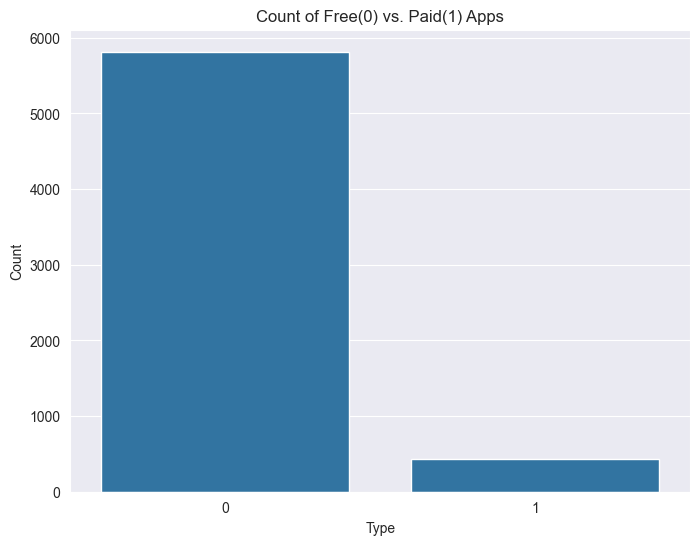

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Type', data=combined_df)
plt.title('Count of Free(0) vs. Paid(1) Apps')
plt.xlabel('Type')
plt.ylabel('Count')
file_path = os.path.join(save_dir, 'free_vs_paid.png')
plt.savefig(file_path)
plt.show()

#### frequency of each genre and category
##### showing the frequency of each genre and category next to eachother

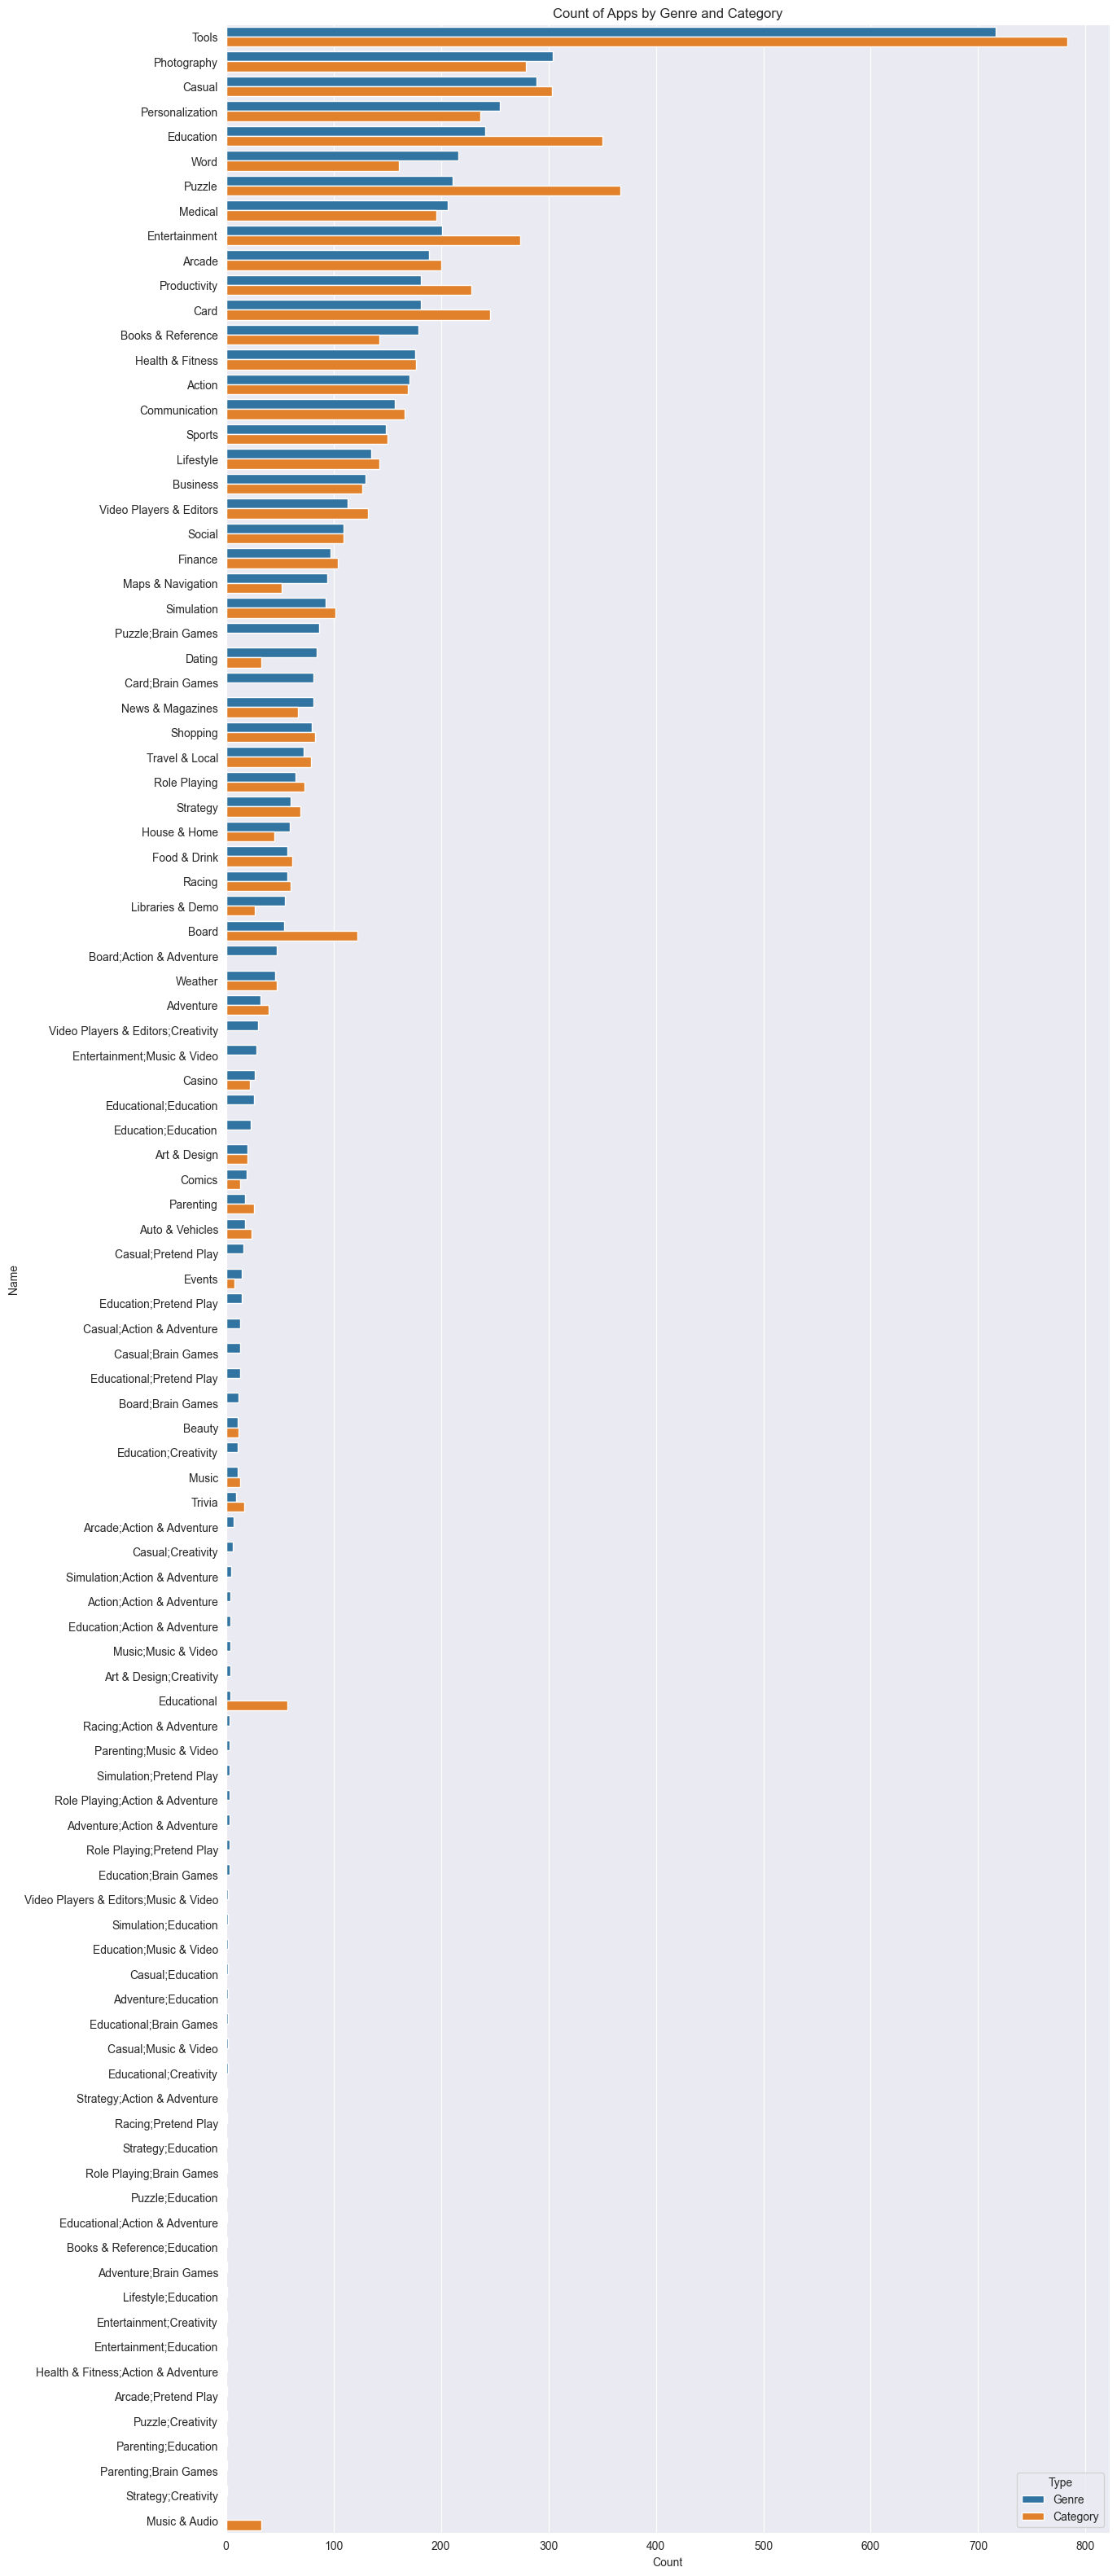

In [195]:
# Calculate the count of apps in each genre
genre_counts = combined_df['Genres'].value_counts().reset_index()
genre_counts.columns = ['Name', 'Count']
genre_counts['Type'] = 'Genre'

# Calculate the count of apps in each category
category_counts = combined_df['Category'].value_counts().reset_index()
category_counts.columns = ['Name', 'Count']
category_counts['Type'] = 'Category'

# Concatenate the counts
combined_counts = pd.concat([genre_counts, category_counts])

# Plot the combined counts
plt.figure(figsize=(14, 40))
sns.barplot(x='Count', y='Name', hue='Type', data=combined_counts)
plt.title('Count of Apps by Genre and Category')
plt.xlabel('Count')
plt.ylabel('Name')
file_path = os.path.join(save_dir, 'Genre_and_category.png')
plt.savefig(file_path)
plt.show()

#### count of content ratings
##### the frequency of each content rating in all apps

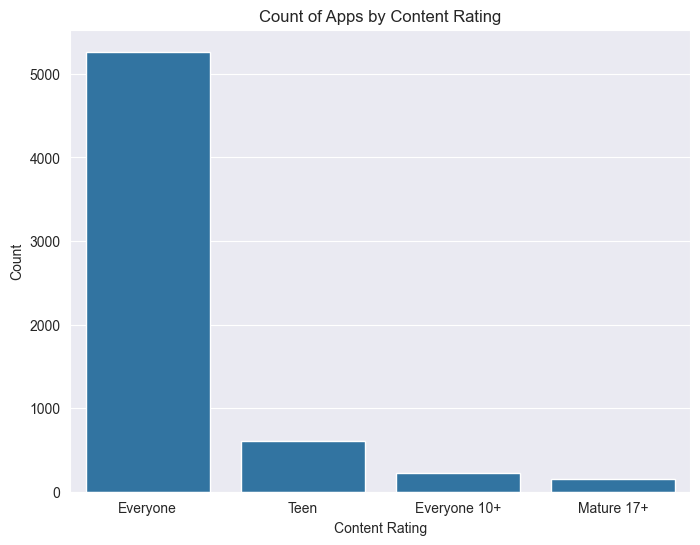

In [196]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Content Rating', data=combined_df)
plt.title('Count of Apps by Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Count')
file_path = os.path.join(save_dir, 'content_rating_freq.png')
plt.savefig(file_path)
plt.show()

#### count of each rating category

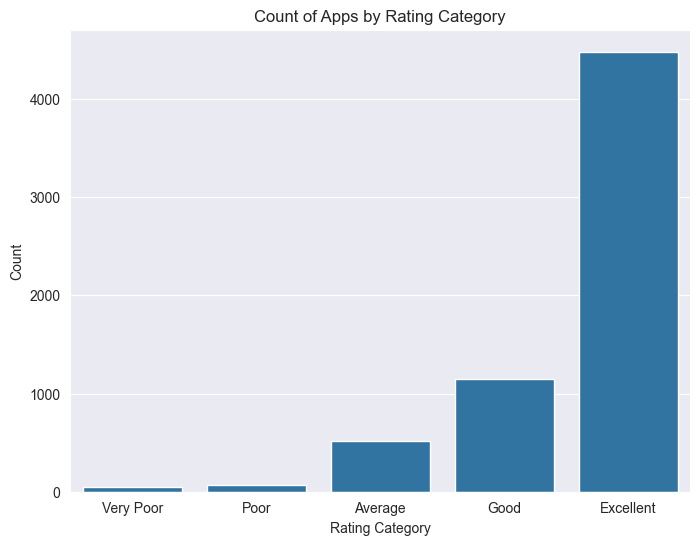

In [197]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Rating_Categorical', data=combined_df)
plt.title('Count of Apps by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Count')
file_path = os.path.join(save_dir, 'rating_freq.png')
plt.savefig(file_path)
plt.show()

#### boxplot for apps ratings based on category
##### we use box plots to visualize the spread and detect outliers in numerical features across different categories

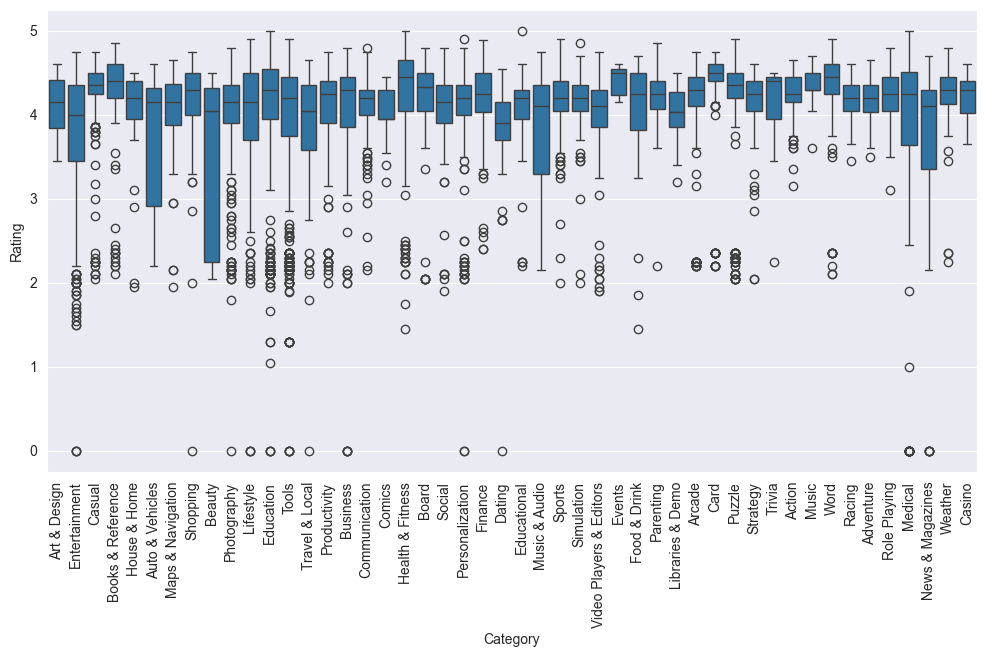

In [198]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Rating', data=combined_df)
plt.xticks(rotation=90)
file_path = os.path.join(save_dir, 'rating_BoxPlot.png')
plt.savefig(file_path)
plt.show()

#### Scatter Plot for Reviews vs. Rating
##### we use scatter plots to explore relationships between two numerical features

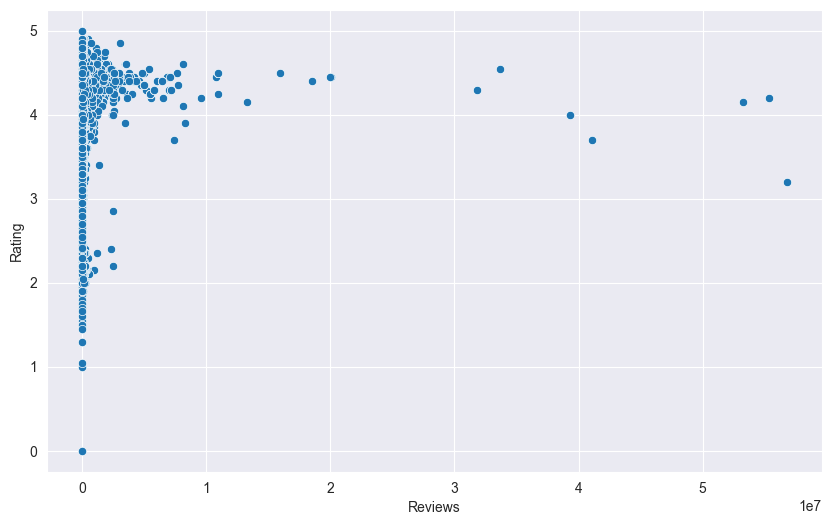

In [199]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Reviews', y='Rating', data=combined_df)
file_path = os.path.join(save_dir, 'review_vs_rating_scatter.png')
plt.savefig(file_path)
plt.show()

#### Time Series Plot for Number of Apps Released Over Time
##### we use line plots to visualize trends over time (number of apps released over time).

C:\Users\ewint\AppData\Local\Temp\ipykernel_12164\555903432.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['Released'] = pd.to_datetime(combined_df['Released'], errors='coerce')


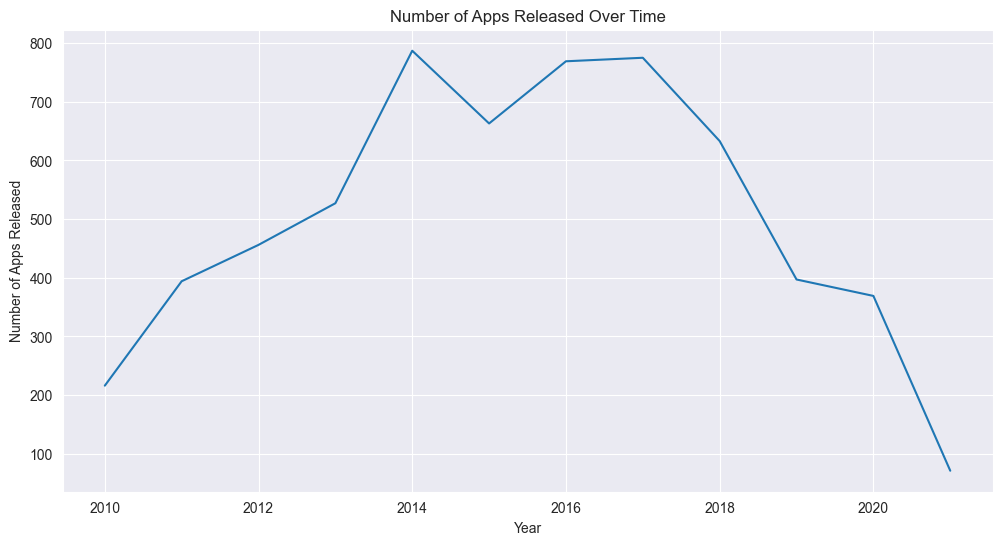

In [200]:
combined_df['Released'] = pd.to_datetime(combined_df['Released'], errors='coerce')
released_per_year = combined_df['Released'].dt.year.value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=released_per_year.index, y=released_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Apps Released')
plt.title('Number of Apps Released Over Time')
file_path = os.path.join(save_dir, 'released_time_series.png')
plt.savefig(file_path)
plt.show()

### Heatmap for Correlation between Numerical Features

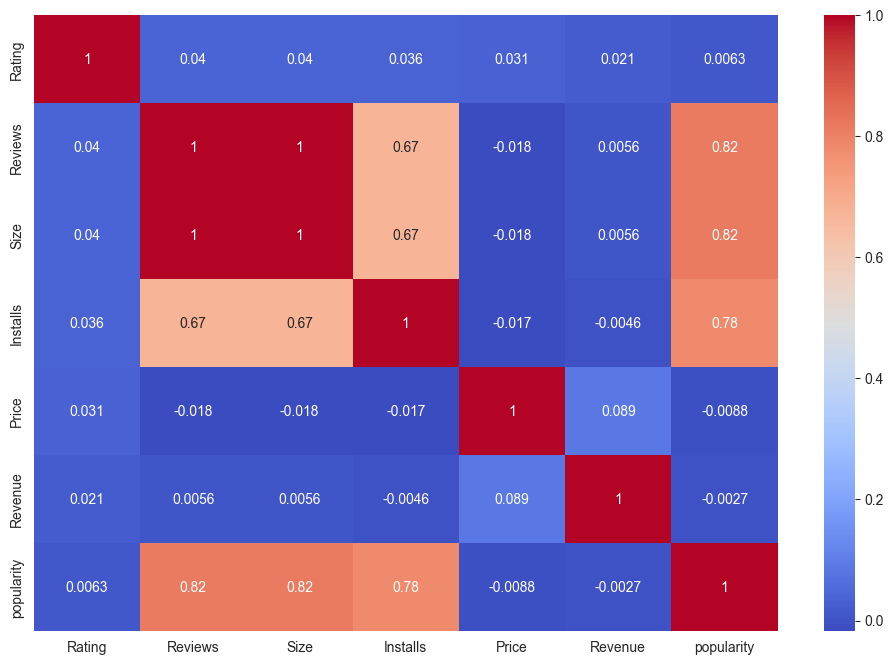

In [201]:
numerical_columns = ['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Revenue', 'popularity']
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df[numerical_columns].corr(), annot=True, cmap='coolwarm')
file_path = os.path.join(save_dir, 'correlation_between_all_columns.png')
plt.savefig(file_path)
plt.show()